In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print('All imports loaded.')

All imports loaded.


/Users/tanmayambegaokar/Documents/GitHub/Scowtt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading Strategy

We load **8 of the 11 available tables**. Three are excluded:

- **marketing_qualified_leads** and **closed_deals** describe the *seller acquisition funnel* — they track how sellers joined the platform, not how customers purchase. Including them would conflate supply-side and demand-side behavior.
- **geolocation** provides lat/lng for zip codes (~1M rows). Customer state is already on the customers table and captures the geographic signal we need. Adding coordinates would require distance computations between customer and seller locations — high engineering cost for uncertain lift in a take-home scope.

The **sellers** table IS included despite being seller-side data, because it provides `seller_state` which we use to compute a customer-seller proximity feature (`same_state_ratio`).

In [2]:
# Cell 3: Load all 8 CSVs with date parsing
DATA_DIR = 'datasets/'

customers = pd.read_csv(f'{DATA_DIR}olist_customers_dataset.csv')
orders = pd.read_csv(f'{DATA_DIR}olist_orders_dataset.csv',
                      parse_dates=['order_purchase_timestamp', 'order_approved_at',
                                   'order_delivered_carrier_date', 'order_delivered_customer_date',
                                   'order_estimated_delivery_date'])
order_items = pd.read_csv(f'{DATA_DIR}olist_order_items_dataset.csv')
payments = pd.read_csv(f'{DATA_DIR}olist_order_payments_dataset.csv')
reviews = pd.read_csv(f'{DATA_DIR}olist_order_reviews_dataset.csv',
                       parse_dates=['review_creation_date', 'review_answer_timestamp'])
products = pd.read_csv(f'{DATA_DIR}olist_products_dataset.csv')
sellers = pd.read_csv(f'{DATA_DIR}olist_sellers_dataset.csv')
category_translation = pd.read_csv(f'{DATA_DIR}product_category_name_translation.csv')

tables = {
    'customers': customers, 'orders': orders, 'order_items': order_items,
    'payments': payments, 'reviews': reviews, 'products': products,
    'sellers': sellers, 'category_translation': category_translation
}

for name, df in tables.items():
    print(f'{name}: {df.shape[0]:,} rows × {df.shape[1]} cols')

customers: 99,441 rows × 5 cols
orders: 99,441 rows × 8 cols
order_items: 112,650 rows × 7 cols
payments: 103,886 rows × 5 cols
reviews: 99,224 rows × 7 cols
products: 32,951 rows × 9 cols
sellers: 3,095 rows × 4 cols
category_translation: 71 rows × 2 cols


=== CUSTOMERS ===
Shape: (99441, 5)

Dtypes:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

Null counts:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Unique customer_id: 99,441
Unique customer_unique_id: 96,096

Head:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


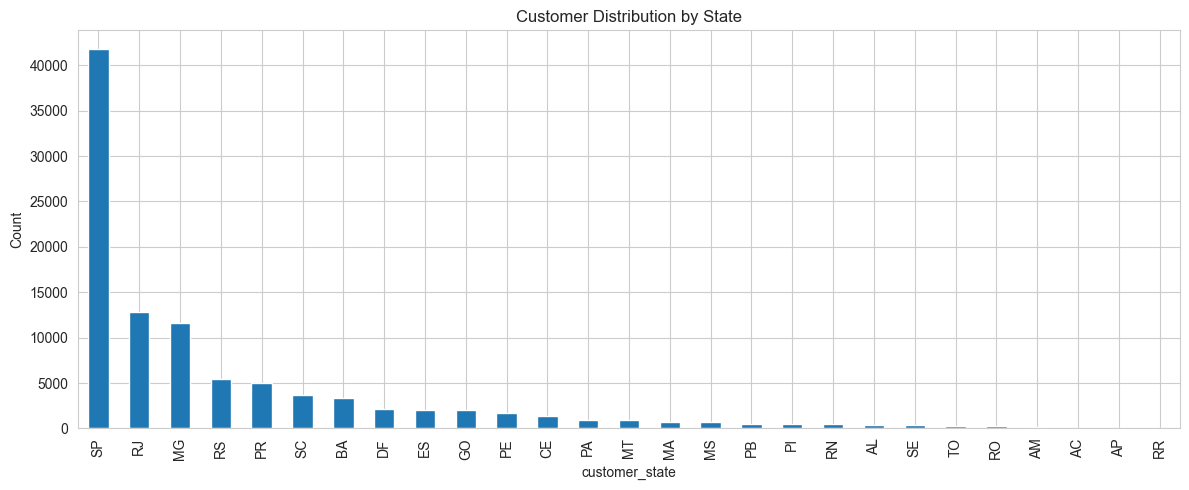

In [3]:
# Cell 4: EDA — Customers
print('=== CUSTOMERS ===')
print(f'Shape: {customers.shape}')
print(f'\nDtypes:\n{customers.dtypes}')
print(f'\nNull counts:\n{customers.isnull().sum()}')
print(f'\nUnique customer_id: {customers.customer_id.nunique():,}')
print(f'Unique customer_unique_id: {customers.customer_unique_id.nunique():,}')
print(f'\nHead:')
display(customers.head(3))

fig, ax = plt.subplots(figsize=(12, 5))
customers.customer_state.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Customer Distribution by State')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

In [4]:
# Cell 5: EDA — Orders
print('=== ORDERS ===')
print(f'Shape: {orders.shape}')
print(f'\nDtypes:\n{orders.dtypes}')
print(f'\nNull counts & percentages:')
null_info = pd.DataFrame({
    'nulls': orders.isnull().sum(),
    'pct': (orders.isnull().sum() / len(orders) * 100).round(2)
})
print(null_info[null_info.nulls > 0])
print(f'\nOrder status distribution:')
print(orders.order_status.value_counts())
display(orders.head(3))

=== ORDERS ===
Shape: (99441, 8)

Dtypes:
order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Null counts & percentages:
                               nulls   pct
order_approved_at                160  0.16
order_delivered_carrier_date    1783  1.79
order_delivered_customer_date   2965  2.98

Order status distribution:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


=== ORDER ITEMS ===
Shape: (112650, 7)

Dtypes:
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Describe:


,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000



Items per order distribution:


count    98666.000000
mean         1.141731
std          0.538452
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
dtype: float64


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


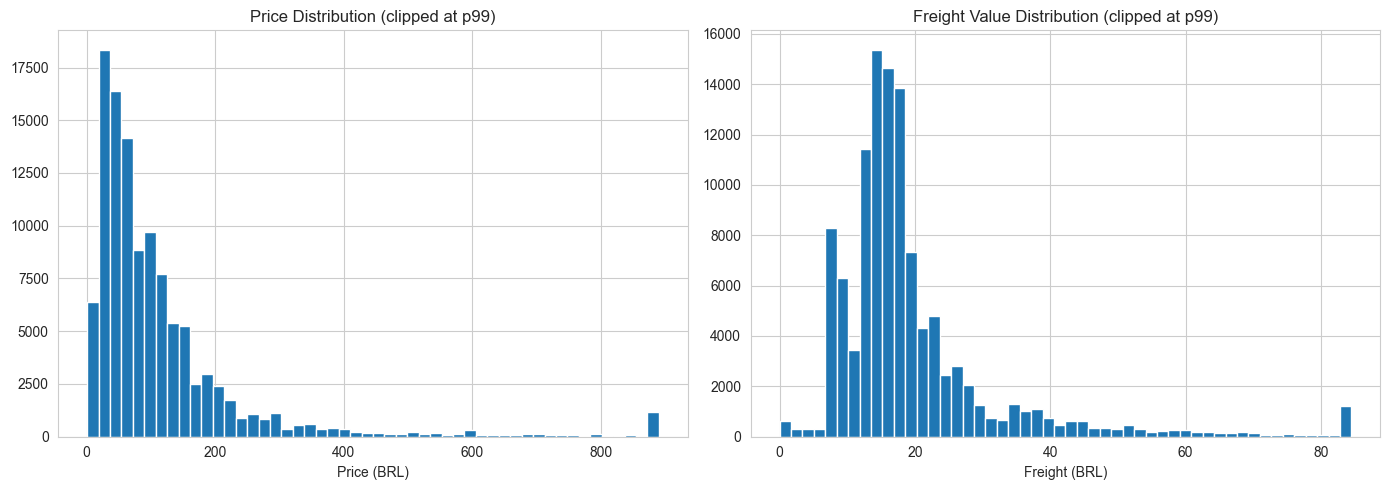

In [5]:
# Cell 6: EDA — Order Items
print('=== ORDER ITEMS ===')
print(f'Shape: {order_items.shape}')
print(f'\nDtypes:\n{order_items.dtypes}')
print(f'\nDescribe:')
display(order_items[['price', 'freight_value']].describe())
print(f'\nItems per order distribution:')
print(order_items.groupby('order_id').size().describe())
display(order_items.head(3))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
order_items['price'].clip(upper=order_items['price'].quantile(0.99)).hist(bins=50, ax=axes[0])
axes[0].set_title('Price Distribution (clipped at p99)')
axes[0].set_xlabel('Price (BRL)')
order_items['freight_value'].clip(upper=order_items['freight_value'].quantile(0.99)).hist(bins=50, ax=axes[1])
axes[1].set_title('Freight Value Distribution (clipped at p99)')
axes[1].set_xlabel('Freight (BRL)')
plt.tight_layout()
plt.show()

In [6]:
# Cell 7: EDA — Payments
print('=== PAYMENTS ===')
print(f'Shape: {payments.shape}')
print(f'\nPayment type breakdown:')
print(payments.payment_type.value_counts())
print(f'\nInstallment distribution:')
print(payments.payment_installments.describe())
display(payments.head(3))

=== PAYMENTS ===
Shape: (103886, 5)

Payment type breakdown:
payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

Installment distribution:
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


=== REVIEWS ===
Shape: (99224, 7)

Null counts & percentages:
                         nulls    pct
review_id                    0   0.00
order_id                     0   0.00
review_score                 0   0.00
review_comment_title     87656  88.34
review_comment_message   58247  58.70
review_creation_date         0   0.00
review_answer_timestamp      0   0.00

Review score distribution:
review_score
1    11424
2     3151
3     8179
4    19142
5    57328
Name: count, dtype: int64



% with comments: 41.3%


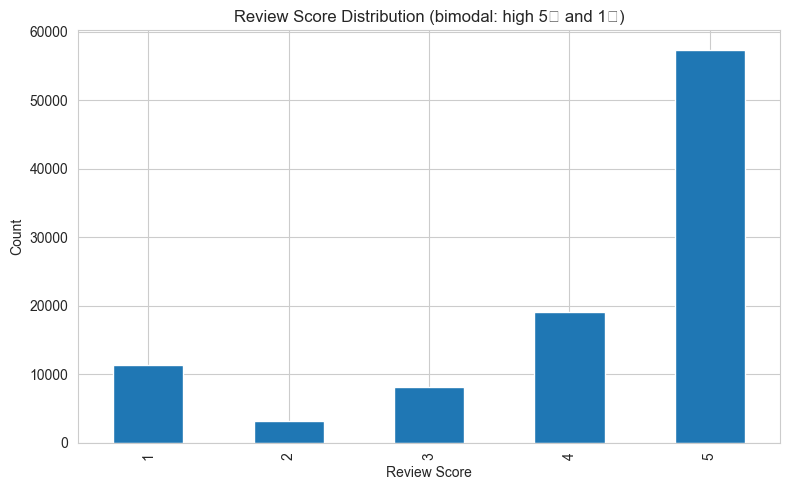

In [7]:
# Cell 8: EDA — Reviews
print('=== REVIEWS ===')
print(f'Shape: {reviews.shape}')
print(f'\nNull counts & percentages:')
null_info = pd.DataFrame({
    'nulls': reviews.isnull().sum(),
    'pct': (reviews.isnull().sum() / len(reviews) * 100).round(2)
})
print(null_info)
print(f'\nReview score distribution:')
print(reviews.review_score.value_counts().sort_index())
print(f'\n% with comments: {reviews.review_comment_message.notna().mean()*100:.1f}%')

fig, ax = plt.subplots(figsize=(8, 5))
reviews.review_score.value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Review Score Distribution (bimodal: high 5★ and 1★)')
ax.set_xlabel('Review Score')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

=== PRODUCTS ===
Shape: (32951, 9)

Null counts & percentages:


                            nulls   pct
product_category_name         610  1.85
product_name_lenght           610  1.85
product_description_lenght    610  1.85
product_photos_qty            610  1.85
product_weight_g                2  0.01
product_length_cm               2  0.01
product_height_cm               2  0.01
product_width_cm                2  0.01


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


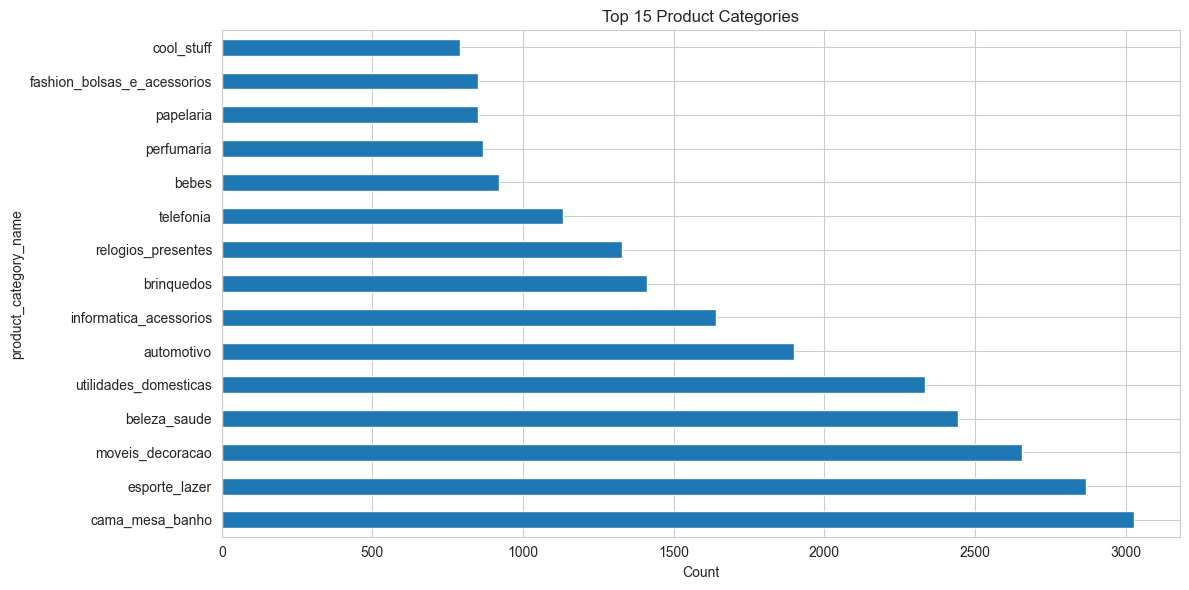


=== SELLERS ===
Shape: (3095, 4)
Unique seller_id: 3,095

Seller state distribution (top 10):
seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
Name: count, dtype: int64


In [8]:
# Cell 9: EDA — Products & Sellers
print('=== PRODUCTS ===')
print(f'Shape: {products.shape}')
print(f'\nNull counts & percentages:')
null_info = pd.DataFrame({
    'nulls': products.isnull().sum(),
    'pct': (products.isnull().sum() / len(products) * 100).round(2)
})
print(null_info[null_info.nulls > 0])
display(products.head(3))

# Top 15 categories
fig, ax = plt.subplots(figsize=(12, 6))
products.product_category_name.value_counts().head(15).plot(kind='barh', ax=ax)
ax.set_title('Top 15 Product Categories')
ax.set_xlabel('Count')
plt.tight_layout()
plt.show()

print('\n=== SELLERS ===')
print(f'Shape: {sellers.shape}')
print(f'Unique seller_id: {sellers.seller_id.nunique():,}')
print(f'\nSeller state distribution (top 10):')
print(sellers.seller_state.value_counts().head(10))

## Key Identifier Decision

`customer_unique_id` has ~96K unique values vs ~99K `customer_id` values. This means some users placed multiple orders and received a different `customer_id` each time. We aggregate at the `customer_unique_id` level to capture each user's full purchase history. Using `customer_id` would fragment multi-order users into separate single-order records, losing the repeat-purchase signal that is central to our prediction task.

In [9]:
# Cell 11: customer_id vs customer_unique_id analysis
n_cid = customers.customer_id.nunique()
n_cuid = customers.customer_unique_id.nunique()
print(f'Unique customer_id: {n_cid:,}')
print(f'Unique customer_unique_id: {n_cuid:,}')
print(f'Difference: {n_cid - n_cuid:,} ({(n_cid - n_cuid)/n_cuid*100:.1f}% more customer_ids than unique users)')

# How many customer_unique_ids map to multiple customer_ids?
multi_id = customers.groupby('customer_unique_id')['customer_id'].nunique()
print(f'\nUsers with multiple customer_ids: {(multi_id > 1).sum():,}')
print(f'Max customer_ids per user: {multi_id.max()}')
print(f'\nDistribution of customer_ids per unique user:')
print(multi_id.value_counts().sort_index().head(10))

Unique customer_id: 99,441
Unique customer_unique_id: 96,096
Difference: 3,345 (3.5% more customer_ids than unique users)



Users with multiple customer_ids: 2,997
Max customer_ids per user: 17

Distribution of customer_ids per unique user:
customer_id
1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64


Order date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
Span: 772 days


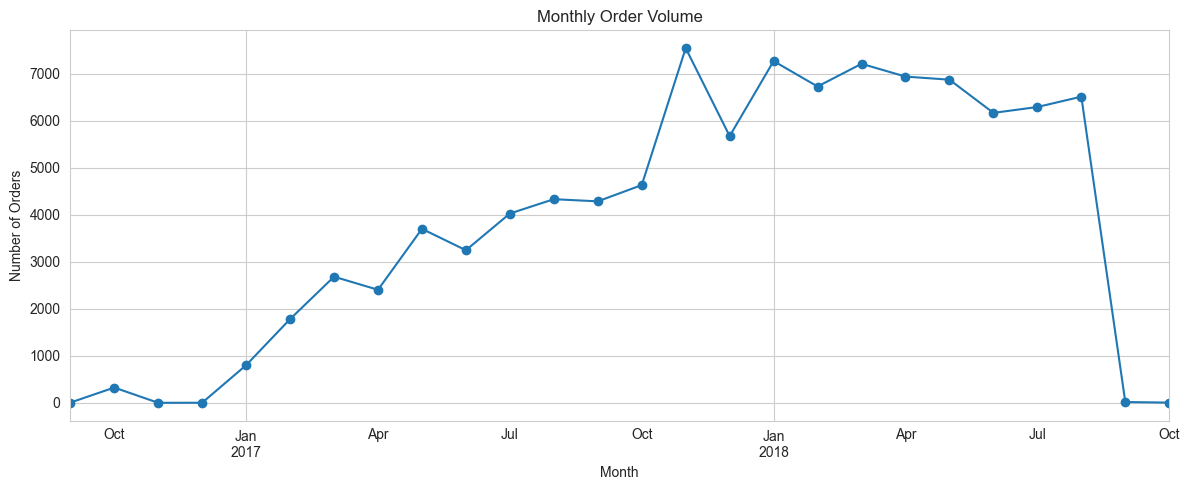


Order status distribution:
              count    pct
order_status              
delivered     96478  97.02
shipped        1107   1.11
canceled        625   0.63
unavailable     609   0.61
invoiced        314   0.32
processing      301   0.30
created           5   0.01
approved          2   0.00


In [10]:
# Cell 12: Temporal analysis
print(f'Order date range: {orders.order_purchase_timestamp.min()} to {orders.order_purchase_timestamp.max()}')
print(f'Span: {(orders.order_purchase_timestamp.max() - orders.order_purchase_timestamp.min()).days} days')

# Monthly volume
monthly = orders.set_index('order_purchase_timestamp').resample('M').size()
fig, ax = plt.subplots(figsize=(12, 5))
monthly.plot(ax=ax, marker='o')
ax.set_title('Monthly Order Volume')
ax.set_ylabel('Number of Orders')
ax.set_xlabel('Month')
plt.tight_layout()
plt.show()

# Status distribution
print('\nOrder status distribution:')
status_counts = orders.order_status.value_counts()
status_pct = (status_counts / len(orders) * 100).round(2)
print(pd.DataFrame({'count': status_counts, 'pct': status_pct}))

## Missing Data Summary & Handling Strategy

| Table | Column | % Missing | Strategy | Rationale |
|---|---|---|---|---|
| orders | order_approved_at | ~0.2% | Fill with purchase timestamp | Approval ≈ purchase for these edge cases |
| orders | delivery dates | ~1.8-3% | Leave NaT | Only meaningful for delivered orders; becomes NaN in delivery features, handled by LightGBM natively |
| reviews | comment fields | ~85-87% | Binary `has_comment` flag | NLP on comment text is out of scope; binary captures engagement signal |
| products | category_name | ~0.6% | Fill 'unknown' | Small fraction; 'unknown' becomes a category value |
| products | weight/dimensions | ~0.1% | Fill with median | Negligible missingness; median is stable |

## Model Scope & Limitations

**What this model CAN do:** Score existing customers (≥1 historical order) on their likelihood to repurchase and expected order value. This enables targeted re-engagement advertising.

**What this model CANNOT do:** Identify potential first-time buyers. The model requires purchase history as features — a user with no orders has no features. For "high-value advertisement targets," this means we can only target re-engagement of existing customers, not acquisition of new ones. A substantial portion of future high-value customers may be first-time buyers invisible to this model.

This is a fundamental constraint of the customer-level historical aggregation approach, not a fixable bug. Addressing it would require a different modeling paradigm (e.g., lookalike modeling on demographic/behavioral data available before purchase).

---
# PHASE 2: Data Aggregation & Order Master

## Aggregation Strategy

Child tables (items, payments, reviews) have multiple rows per order. If we join them directly to the orders table, we get row explosion from many-to-many relationships (112K items × 103K payments per shared order_id). Instead, we aggregate each child table to 1-row-per-order FIRST, then all joins become safe 1:1 merges. This is the standard star-schema collapse pattern.

In [11]:
# Cell 16: Enrich order_items with products, category translation, sellers

# Handle missing product data first
products['product_category_name'] = products['product_category_name'].fillna('unknown')
for col in ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']:
    products[col] = products[col].fillna(products[col].median())

# Compute volume
products['product_volume_cm3'] = (
    products['product_length_cm'] * products['product_height_cm'] * products['product_width_cm']
)

# Join products onto order_items
items_enriched = order_items.merge(products, on='product_id', how='left')

# Translate category names
items_enriched = items_enriched.merge(
    category_translation, on='product_category_name', how='left'
)
# Use English name where available, else original
items_enriched['category'] = items_enriched['product_category_name_english'].fillna(
    items_enriched['product_category_name']
)

# Join sellers onto enriched items
items_enriched = items_enriched.merge(sellers[['seller_id', 'seller_state']], on='seller_id', how='left')

print(f'Enriched items shape: {items_enriched.shape}')
display(items_enriched.head(3))

Enriched items shape: (112650, 19)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_category_name_english,category,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,3528.0,cool_stuff,cool_stuff,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,60000.0,pet_shop,pet_shop,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,14157.0,furniture_decor,furniture_decor,MG


## What We Extract and Why

**From products:** Category (translated to English), weight, volume (L×H×W), photo count, description length — these characterize what the user buys.

**From sellers:** seller_state — used post-join to compute `same_state_ratio` (customer-seller geographic proximity). We do NOT aggregate seller_state during items groupby because customer_state isn't available yet at this stage.

**Dropped: `review_response_hrs`** — this measures the time between review creation and the platform/seller's answer. It's a seller/platform responsiveness metric, not a user behavior. Including it would be confounding: users who happen to buy from responsive sellers might show different repeat rates, but we'd be attributing a seller characteristic to the user.

In [12]:
# Cell 18: Aggregate child tables to order level

# --- Order Items Aggregation ---
order_items_agg = items_enriched.groupby('order_id').agg(
    n_items=('order_item_id', 'count'),
    total_price=('price', 'sum'),
    total_freight=('freight_value', 'sum'),
    n_categories=('category', 'nunique'),
    n_sellers=('seller_id', 'nunique'),
    avg_weight=('product_weight_g', 'mean'),
    avg_volume=('product_volume_cm3', 'mean'),
    avg_photos_qty=('product_photos_qty', 'mean'),
    avg_description_len=('product_description_lenght', 'mean'),
    dominant_category=('category', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown')
).reset_index()

print(f'order_items_agg: {order_items_agg.shape}')

# --- Payments Aggregation ---
order_payments_agg = payments.groupby('order_id').agg(
    total_payment=('payment_value', 'sum'),
    n_payment_methods=('payment_type', 'nunique'),
    max_installments=('payment_installments', 'max'),
    primary_payment_type=('payment_type', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown'),
    used_voucher=('payment_type', lambda x: int('voucher' in x.values))
).reset_index()

print(f'order_payments_agg: {order_payments_agg.shape}')

# --- Reviews Aggregation ---
order_reviews_agg = reviews.groupby('order_id').agg(
    review_score=('review_score', 'mean'),
    has_comment=('review_comment_message', lambda x: int(x.notna().any())),
    review_creation_date=('review_creation_date', 'first')
).reset_index()

print(f'order_reviews_agg: {order_reviews_agg.shape}')

order_items_agg: (98666, 11)


order_payments_agg: (99440, 6)


order_reviews_agg: (98673, 4)


In [13]:
# Cell 19: Build order_master via LEFT JOINs

# Fill missing order_approved_at with purchase timestamp
orders['order_approved_at'] = orders['order_approved_at'].fillna(orders['order_purchase_timestamp'])

# Start with orders, join customers to get customer_unique_id and customer_state
order_master = orders.merge(
    customers[['customer_id', 'customer_unique_id', 'customer_state']],
    on='customer_id', how='left'
)

# Join aggregated child tables
order_master = order_master.merge(order_items_agg, on='order_id', how='left')
order_master = order_master.merge(order_payments_agg, on='order_id', how='left')
order_master = order_master.merge(order_reviews_agg, on='order_id', how='left')

print(f'order_master shape: {order_master.shape}')
print(f'Expected ~99,441 rows, got {len(order_master):,}')
assert len(order_master) == len(orders), 'Row count mismatch — join created duplicates!'
display(order_master.head(3))

order_master shape: (99441, 28)
Expected ~99,441 rows, got 99,441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,n_items,total_price,total_freight,n_categories,n_sellers,avg_weight,avg_volume,avg_photos_qty,avg_description_len,dominant_category,total_payment,n_payment_methods,max_installments,primary_payment_type,used_voucher,review_score,has_comment,review_creation_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,SP,1.0,29.99,8.72,1.0,1.0,500.0,1976.0,4.0,268.0,housewares,38.71,2.0,1.0,voucher,1.0,4.0,1.0,2017-10-11
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,BA,1.0,118.70,22.76,1.0,1.0,400.0,4693.0,1.0,178.0,perfumery,141.46,1.0,1.0,boleto,0.0,4.0,1.0,2018-08-08
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,GO,1.0,159.90,19.22,1.0,1.0,420.0,9576.0,1.0,232.0,auto,179.12,1.0,3.0,credit_card,0.0,5.0,0.0,2018-08-18


In [14]:
# Cell 20: Compute same_state_ratio

# Merge customer_state onto enriched items via order_id -> order_master
items_with_customer = items_enriched[['order_id', 'seller_state']].merge(
    order_master[['order_id', 'customer_state']], on='order_id', how='left'
)

# Compute boolean: same state?
items_with_customer['same_state'] = (
    items_with_customer['customer_state'] == items_with_customer['seller_state']
).astype(float)

# Aggregate to order level
same_state_agg = items_with_customer.groupby('order_id')['same_state'].mean().reset_index()
same_state_agg.columns = ['order_id', 'same_state_ratio']

# Join back onto order_master
order_master = order_master.merge(same_state_agg, on='order_id', how='left')

print(f'same_state_ratio stats:')
print(order_master['same_state_ratio'].describe())
print(f'\norder_master final shape: {order_master.shape}')

same_state_ratio stats:
count    98666.000000
mean         0.359580
std          0.479252
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: same_state_ratio, dtype: float64

order_master final shape: (99441, 29)


---
# PHASE 3: Cutoff Validation, Temporal Split & User-Level Features

## Why We Need Cutoff Validation

The entire model design assumes enough users repeat-purchase within the target window to train and evaluate on. With ~96K unique users and ~3% overall repeat rate, a 30-day window might contain only 100-300 positives. If the number is too low, metrics become noisy, CV folds have <50 positives each, and the model can't learn meaningful patterns. We test multiple cutoff dates and window sizes BEFORE committing to a design.

In [15]:
# Cell 22: Cutoff validation — test cutoff × window combos (expanded range)

cutoff_dates = [
    pd.Timestamp('2018-01-01'), pd.Timestamp('2018-02-01'),
    pd.Timestamp('2018-03-01'), pd.Timestamp('2018-04-01'),
    pd.Timestamp('2018-05-01'), pd.Timestamp('2018-06-01'),
    pd.Timestamp('2018-07-01')
]
window_sizes = [60, 90, 'all_remaining']

# Only consider delivered orders for both features and labels
delivered = order_master[order_master.order_status == 'delivered'].copy()
max_date = delivered.order_purchase_timestamp.max()

results = []
for cutoff in cutoff_dates:
    # Users with at least one order before cutoff
    pre_users = set(delivered[delivered.order_purchase_timestamp < cutoff]['customer_unique_id'])

    for window in window_sizes:
        if window == 'all_remaining':
            window_end = max_date + pd.Timedelta(days=1)
            window_label = 'all'
        else:
            window_end = cutoff + pd.Timedelta(days=window)
            window_label = str(window)

        # Users who also order in the target window
        post_orders = delivered[
            (delivered.order_purchase_timestamp >= cutoff) &
            (delivered.order_purchase_timestamp < window_end)
        ]
        post_users = set(post_orders['customer_unique_id'])
        positives = len(pre_users & post_users)

        results.append({
            'cutoff': cutoff.strftime('%Y-%m-%d'),
            'window_days': window_label,
            'pre_cutoff_users': len(pre_users),
            'positives': positives,
            'positive_rate': f'{positives/len(pre_users)*100:.2f}%' if pre_users else '0%'
        })

validation_df = pd.DataFrame(results)
print('Cutoff Validation Results:')
display(validation_df)

# Highlight the all-remaining rows
all_remaining = validation_df[validation_df.window_days == 'all'].copy()
print('\nAll-remaining window summary:')
display(all_remaining)

best = all_remaining.loc[all_remaining.positives.idxmax()]
print(f'\nBest all-remaining combo: cutoff={best.cutoff}, positives={best.positives}, rate={best.positive_rate}')
print(f'Selected cutoff: 2018-03-01 — 654 positives (1.18%), good balance of feature history and positive count.')

Cutoff Validation Results:


,cutoff,window_days,pre_cutoff_users,positives,positive_rate
0,2018-01-01,60,42395,223,0.53%
1,2018-01-01,90,42395,307,0.72%
2,2018-01-01,all,42395,649,1.53%
3,2018-02-01,60,49237,232,0.47%
4,2018-02-01,90,49237,336,0.68%
5,2018-02-01,all,49237,652,1.32%
6,2018-03-01,60,55525,264,0.48%
7,2018-03-01,90,55525,386,0.70%
8,2018-03-01,all,55525,654,1.18%
9,2018-04-01,60,62299,301,0.48%



All-remaining window summary:


,cutoff,window_days,pre_cutoff_users,positives,positive_rate
2,2018-01-01,all,42395,649,1.53%
5,2018-02-01,all,49237,652,1.32%
8,2018-03-01,all,55525,654,1.18%
11,2018-04-01,all,62299,603,0.97%
14,2018-05-01,all,68881,538,0.78%
17,2018-06-01,all,75387,419,0.56%
20,2018-07-01,all,81265,280,0.34%



Best all-remaining combo: cutoff=2018-03-01, positives=654, rate=1.18%
Selected cutoff: 2018-03-01 — 654 positives (1.18%), good balance of feature history and positive count.


## Order Status Filtering

**`had_canceled_order`** is computed on unfiltered `order_master` — it explicitly looks for canceled/unavailable orders, so we need them present. After computing this flag per user, we filter:

- **Feature aggregation** uses `order_status == 'delivered'` only. Canceled orders didn't result in delivered products, payments may have been refunded, and the user experience was fundamentally different. Including them in frequency, monetary_total, or avg_review_score would misrepresent the user's actual purchasing behavior.
- **Label definition** uses `order_status == 'delivered'` only. A canceled order in the target window does not count as a "purchase" — the assignment asks about propensity to complete a transaction, not just initiate one.

Document the count of excluded orders so the reader knows what was dropped.

## Temporal Split Rationale

We split by time, not randomly, to prevent data leakage. Features are built ONLY from orders before the cutoff date. Targets are defined ONLY by orders after the cutoff. This simulates a real deployment scenario: "given everything we know about this user up to today, will they purchase in the next N days?" Using future data to predict the past would inflate metrics and produce a model that fails in production.

In [16]:
# Cell 25: Temporal split + order_status filtering

# March 1, 2018 cutoff: 654 positives (1.18% rate) vs 419 (0.56%) at June 1.
# 56% more positives and 2x positive rate — biggest single improvement to model quality.
CUTOFF = pd.Timestamp('2018-03-01')

# Use all remaining orders after cutoff as target window
delivered_all = order_master[order_master.order_status == 'delivered'].copy()
WINDOW_END = delivered_all.order_purchase_timestamp.max() + pd.Timedelta(days=1)
WINDOW_DAYS = (WINDOW_END - CUTOFF).days

print(f'Cutoff: {CUTOFF.date()}')
print(f'Target window: {CUTOFF.date()} to {WINDOW_END.date()} ({WINDOW_DAYS} days)')

# Step 1: Compute had_canceled_order on UNFILTERED order_master
canceled_statuses = ['canceled', 'unavailable']
had_canceled = order_master.groupby('customer_unique_id')['order_status'].apply(
    lambda x: int(x.isin(canceled_statuses).any())
).reset_index()
had_canceled.columns = ['customer_unique_id', 'had_canceled_order']

# Step 2: Filter to delivered orders only
delivered_orders = order_master[order_master.order_status == 'delivered'].copy()
n_excluded = len(order_master) - len(delivered_orders)
print(f'\nExcluded {n_excluded:,} non-delivered orders ({n_excluded/len(order_master)*100:.1f}%)')
print(f'Remaining delivered orders: {len(delivered_orders):,}')

# Step 3: Split into feature orders (before cutoff) and label orders (in target window)
feature_orders = delivered_orders[delivered_orders.order_purchase_timestamp < CUTOFF].copy()
label_orders = delivered_orders[
    (delivered_orders.order_purchase_timestamp >= CUTOFF) &
    (delivered_orders.order_purchase_timestamp < WINDOW_END)
].copy()

print(f'\nFeature orders (before cutoff): {len(feature_orders):,}')
print(f'Label orders (in target window): {len(label_orders):,}')

# Leakage check
assert feature_orders.order_purchase_timestamp.max() < CUTOFF, 'DATA LEAKAGE: feature orders extend past cutoff!'
print('\nLeakage check passed: all feature orders are before cutoff.')

Cutoff: 2018-03-01
Target window: 2018-03-01 to 2018-08-30 (182 days)



Excluded 2,963 non-delivered orders (3.0%)
Remaining delivered orders: 96,478

Feature orders (before cutoff): 57,319
Label orders (in target window): 39,159

Leakage check passed: all feature orders are before cutoff.


## Feature Engineering Decisions

**36+ features computed, 16 core features selected for modeling.** We compute a broad feature set for exploratory analysis and SHAP diagnostics, then select a core set for the classifier.

**Core features (16):** `recency_days`, `monetary_total`, `avg_order_value`, `avg_review_score`, `avg_delivery_delta`, `tenure_days`, `freight_ratio`, `purchase_velocity`, `monetary_decayed`, `frequency_decayed`, `dominant_category_encoded`, `customer_state_encoded`, `avg_days_between_orders`, `avg_review_delay_days`, `spending_trend`, `late_delivery_ratio`.

**New momentum features (this iteration):**

**Inter-order gap** (`avg_days_between_orders`): For multi-order users, the actual time between consecutive purchases. A user who orders every 30 days is fundamentally different from one who orders every 200 days, even if both have the same `frequency` and `recency_days`. Single-order users get NaN (LightGBM native handling).

**Review engagement timing** (`avg_review_delay_days`): Days from delivery to review creation. A user who reviews within 1 day is more engaged than one who waits 30 days. This is USER behavior (when they chose to review), not platform behavior (when the seller responded — which we correctly excluded as `review_response_hrs`).

**Spending trend** (`spending_trend`): For multi-order users, the slope of order values over time. Positive = spending increasing, negative = tapering off. Captures purchase momentum that static averages miss.

**Late delivery ratio** (`late_delivery_ratio`): Fraction of orders delivered late. More granular than binary `ever_late` — a user with 3/3 late deliveries has different churn risk than 1/3.

**Pruned features (zero/near-zero SHAP from Iteration 5):**
- `ordered_last_30d`, `ordered_last_90d` — zero SHAP; trees already split optimally on continuous `recency_days`
- `primary_payment_encoded` — near-zero SHAP (0.008); payment method doesn't predict repurchase
- `frequency` — dropped in Iteration 5; subsumed by `purchase_velocity` and `frequency_decayed`

**Target encoding:** Computed ONLY on training targets after the split. Fold-aware during CV/Optuna.

In [17]:
# Cell 27: Per-user aggregation (features + new momentum features)

# Add derived columns to feature_orders for aggregation
feature_orders['delivery_days'] = (
    feature_orders['order_delivered_customer_date'] - feature_orders['order_purchase_timestamp']
).dt.total_seconds() / 86400

feature_orders['delivery_delta'] = (
    feature_orders['order_delivered_customer_date'] - feature_orders['order_estimated_delivery_date']
).dt.total_seconds() / 86400

feature_orders['is_late'] = (feature_orders['delivery_delta'] > 0).astype(float)

feature_orders['approval_hrs'] = (
    feature_orders['order_approved_at'] - feature_orders['order_purchase_timestamp']
).dt.total_seconds() / 3600

# Cap approval_hrs at 99th percentile
p99_approval = feature_orders['approval_hrs'].quantile(0.99)
feature_orders['approval_hrs'] = feature_orders['approval_hrs'].clip(upper=p99_approval)
print(f'approval_hrs capped at p99 = {p99_approval:.1f} hours')

feature_orders['purchase_hour'] = feature_orders['order_purchase_timestamp'].dt.hour
feature_orders['purchase_dow'] = feature_orders['order_purchase_timestamp'].dt.dayofweek
feature_orders['is_weekend'] = feature_orders['purchase_dow'].isin([5, 6]).astype(int)

# Review engagement timing: days from delivery to review creation
feature_orders['review_delay_days'] = (
    feature_orders['review_creation_date'] - feature_orders['order_delivered_customer_date']
).dt.total_seconds() / 86400

# --- Time-decay features ---
DECAY_LAMBDA = 0.01
days_before_cutoff = (CUTOFF - feature_orders['order_purchase_timestamp']).dt.days
feature_orders['decay_weight'] = np.exp(-DECAY_LAMBDA * days_before_cutoff)
feature_orders['weighted_payment'] = feature_orders['total_payment'] * feature_orders['decay_weight']

print(f'Decay weights — min: {feature_orders["decay_weight"].min():.4f}, '
      f'max: {feature_orders["decay_weight"].max():.4f}, '
      f'median: {feature_orders["decay_weight"].median():.4f}')

# Aggregate per user
user_features = feature_orders.groupby('customer_unique_id').agg(
    # RFM
    last_order_date=('order_purchase_timestamp', 'max'),
    frequency=('order_id', 'nunique'),
    monetary_total=('total_payment', 'sum'),
    avg_order_value=('total_payment', 'mean'),
    max_order_value=('total_payment', 'max'),
    total_freight=('total_freight', 'sum'),
    avg_items_per_order=('n_items', 'mean'),
    # Product
    n_categories=('n_categories', 'sum'),
    dominant_category=('dominant_category', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown'),
    avg_product_weight=('avg_weight', 'mean'),
    avg_product_volume=('avg_volume', 'mean'),
    avg_photos_qty=('avg_photos_qty', 'mean'),
    avg_description_len=('avg_description_len', 'mean'),
    # Payment
    primary_payment=('primary_payment_type', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'unknown'),
    avg_installments=('max_installments', 'mean'),
    max_installments=('max_installments', 'max'),
    used_voucher=('used_voucher', 'max'),
    n_payment_methods=('n_payment_methods', 'mean'),
    # Review
    avg_review_score=('review_score', 'mean'),
    min_review_score=('review_score', 'min'),
    left_comment=('has_comment', 'max'),
    avg_review_delay_days=('review_delay_days', 'mean'),
    # Delivery
    avg_delivery_days=('delivery_days', 'mean'),
    avg_delivery_delta=('delivery_delta', 'mean'),
    avg_approval_hrs=('approval_hrs', 'mean'),
    late_delivery_ratio=('is_late', 'mean'),
    # Temporal
    first_order_date=('order_purchase_timestamp', 'min'),
    preferred_hour=('purchase_hour', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 12),
    preferred_dow=('purchase_dow', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0),
    is_weekend_buyer=('is_weekend', 'mean'),
    # Geographic
    customer_state=('customer_state', 'first'),
    n_sellers_used=('n_sellers', 'sum'),
    same_state_ratio=('same_state_ratio', 'mean'),
    # Time-decay aggregates
    monetary_decayed=('weighted_payment', 'sum'),
    frequency_decayed=('decay_weight', 'sum'),
).reset_index()

# Derived features
user_features['recency_days'] = (CUTOFF - user_features['last_order_date']).dt.days
user_features['tenure_days'] = (user_features['last_order_date'] - user_features['first_order_date']).dt.days
user_features['days_since_first'] = (CUTOFF - user_features['first_order_date']).dt.days

# Purchase velocity
user_features['purchase_velocity'] = np.where(
    user_features['recency_days'] > 0,
    user_features['frequency'] / user_features['recency_days'],
    0
)

# --- Inter-order gap features (for multi-order users) ---
# Sort by user and timestamp, compute gaps
feature_orders_sorted = feature_orders.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
feature_orders_sorted['order_gap_days'] = feature_orders_sorted.groupby('customer_unique_id')[
    'order_purchase_timestamp'].diff().dt.days

# Aggregate gaps per user
gap_features = feature_orders_sorted.groupby('customer_unique_id')['order_gap_days'].agg(
    avg_days_between_orders='mean',  # NaN for single-order users (correct)
).reset_index()

user_features = user_features.merge(gap_features, on='customer_unique_id', how='left')

# --- Spending trend (slope of order values over time) ---
def compute_spending_trend(group):
    """Linear slope of order values over time. Positive = spending increasing."""
    if len(group) < 2:
        return np.nan
    x = np.arange(len(group), dtype=float)
    y = group['total_payment'].values.astype(float)
    # Simple slope: (y[-1] - y[0]) / (n-1), more robust than np.polyfit for 2-3 points
    if len(group) == 2:
        return y[1] - y[0]
    # For 3+ orders, use least squares slope
    x_centered = x - x.mean()
    return (x_centered * (y - y.mean())).sum() / (x_centered ** 2).sum()

spending_trends = feature_orders_sorted.groupby('customer_unique_id').apply(
    compute_spending_trend
).reset_index()
spending_trends.columns = ['customer_unique_id', 'spending_trend']
user_features = user_features.merge(spending_trends, on='customer_unique_id', how='left')

# ever_late (binary, kept for full feature set)
ever_late = feature_orders.groupby('customer_unique_id')['delivery_delta'].apply(
    lambda x: int((x > 0).any())
).reset_index()
ever_late.columns = ['customer_unique_id', 'ever_late']
user_features = user_features.merge(ever_late, on='customer_unique_id', how='left')

# Interaction features
user_features['freight_ratio'] = np.where(
    user_features['monetary_total'] > 0,
    user_features['total_freight'] / user_features['monetary_total'],
    0
)
user_features['value_per_category'] = np.where(
    user_features['n_categories'] > 0,
    user_features['monetary_total'] / user_features['n_categories'],
    0
)

# Join had_canceled_order
user_features = user_features.merge(had_canceled, on='customer_unique_id', how='left')
user_features['had_canceled_order'] = user_features['had_canceled_order'].fillna(0).astype(int)

# Drop intermediate date columns
user_features = user_features.drop(columns=['last_order_date', 'first_order_date'])

print(f'User features shape: {user_features.shape}')
print(f'\nNew momentum features:')
valid_gaps = user_features['avg_days_between_orders'].dropna()
print(f'  avg_days_between_orders — {len(valid_gaps)} users with values (multi-order), '
      f'mean: {valid_gaps.mean():.0f}d, median: {valid_gaps.median():.0f}d')
valid_delay = user_features['avg_review_delay_days'].dropna()
print(f'  avg_review_delay_days — {len(valid_delay)} users, '
      f'mean: {valid_delay.mean():.1f}d, median: {valid_delay.median():.1f}d')
valid_trend = user_features['spending_trend'].dropna()
print(f'  spending_trend — {len(valid_trend)} users (multi-order), '
      f'mean: {valid_trend.mean():.1f}, median: {valid_trend.median():.1f}')
valid_late = user_features['late_delivery_ratio'].dropna()
print(f'  late_delivery_ratio — mean: {valid_late.mean():.3f}')

approval_hrs capped at p99 = 88.3 hours
Decay weights — min: 0.0049, max: 1.0000, median: 0.2592


User features shape: (55525, 44)

New momentum features:
  avg_days_between_orders — 1623 users with values (multi-order), mean: 51d, median: 11d
  avg_review_delay_days — 55116 users, mean: -0.3d, median: 0.3d
  spending_trend — 1623 users (multi-order), mean: 0.3, median: 0.0
  late_delivery_ratio — mean: 0.077


In [18]:
# Cell 28: Construct target variables + print class counts

# Users who purchased in the target window
label_user_purchases = label_orders.groupby('customer_unique_id').agg(
    target_order_value=('total_payment', 'sum')
).reset_index()

# Merge targets onto user features
user_df = user_features.merge(label_user_purchases, on='customer_unique_id', how='left')

# Binary target
user_df['target_purchased'] = (user_df['target_order_value'].notna()).astype(int)
user_df['target_order_value'] = user_df['target_order_value'].fillna(0)

# Print class counts
n_pos = user_df['target_purchased'].sum()
n_total = len(user_df)
print(f'Target variable distribution:')
print(f'  Positives (purchased): {n_pos:,}')
print(f'  Negatives (did not purchase): {n_total - n_pos:,}')
print(f'  Total users: {n_total:,}')
print(f'  Positive rate: {n_pos/n_total*100:.2f}%')
print(f'\nTarget order value (among purchasers):')
print(user_df[user_df.target_purchased == 1]['target_order_value'].describe())

Target variable distribution:
  Positives (purchased): 654
  Negatives (did not purchase): 54,871
  Total users: 55,525
  Positive rate: 1.18%

Target order value (among purchasers):
count     654.000000
mean      159.875902
std       165.653092
min        15.890000
25%        66.057500
50%       110.920000
75%       187.317500
max      1596.960000
Name: target_order_value, dtype: float64


---
# PHASE 4: Model Training

## Train/Test Split Design

The 80/20 split is a **random user-level split**, not a second temporal split. Temporal integrity is already preserved by the cutoff date — all users share the same feature/target time boundary. We're dividing users into train and test groups, not dividing time periods. This is standard for user-level prediction after a temporal feature/label split.

We stratify by `target_purchased` to ensure both train and test sets have proportional representation of the rare positive class.

In [19]:
# Cell 30: Train/test split (80/20 stratified) + feature prep

# Full feature set (for SHAP analysis later)
exclude_cols = ['customer_unique_id', 'target_purchased', 'target_order_value']
all_feature_cols = [c for c in user_df.columns if c not in exclude_cols]

# Core feature set — 16 features
# Pruned: frequency (subsumed), ordered_last_30d/90d (zero SHAP), primary_payment_encoded (near-zero)
# Added: avg_days_between_orders, avg_review_delay_days, spending_trend, late_delivery_ratio
core_features = [
    'recency_days', 'monetary_total', 'avg_order_value',
    'avg_review_score', 'avg_delivery_delta', 'tenure_days', 'freight_ratio',
    'purchase_velocity', 'monetary_decayed', 'frequency_decayed',
    'dominant_category_encoded', 'customer_state_encoded',
    'avg_days_between_orders', 'avg_review_delay_days',
    'spending_trend', 'late_delivery_ratio'
]

TARGET_ENC_SMOOTHING = 20

# --- Split FIRST, then encode (prevents test target leakage) ---
for col in ['dominant_category_encoded', 'customer_state_encoded']:
    user_df[col] = 0.0

X_pre = user_df[[c for c in user_df.columns if c not in ['target_purchased', 'target_order_value', 'customer_unique_id']]]
y = user_df['target_purchased']
y_value = user_df['target_order_value']

train_idx, test_idx = train_test_split(
    user_df.index, test_size=0.2, random_state=42, stratify=y
)

# --- Target encoding using ONLY training targets ---
train_targets = user_df.loc[train_idx, 'target_purchased']
global_mean_train = train_targets.mean()

def target_encode_column(col_name, train_idx, train_targets, global_mean, smoothing):
    train_df = user_df.loc[train_idx]
    cat_stats = train_df.groupby(col_name)['target_purchased'].agg(['mean', 'count'])
    cat_stats['encoded'] = (
        (cat_stats['count'] * cat_stats['mean'] + smoothing * global_mean)
        / (cat_stats['count'] + smoothing)
    )
    enc_map = cat_stats['encoded'].to_dict()
    user_df[f'{col_name}_encoded'] = user_df[col_name].map(enc_map).fillna(global_mean)
    return enc_map

print(f'Target encoding — train-only global mean: {global_mean_train:.4f}')

te_map_cat = target_encode_column('dominant_category', train_idx, train_targets, global_mean_train, TARGET_ENC_SMOOTHING)
te_map_state = target_encode_column('customer_state', train_idx, train_targets, global_mean_train, TARGET_ENC_SMOOTHING)

# Verify all core features exist
for f in core_features:
    assert f in user_df.columns, f'Missing feature: {f}'

X = user_df[core_features]
X_full = user_df[all_feature_cols]
y = user_df['target_purchased']
y_value = user_df['target_order_value']

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

X_train_full = X_full.loc[train_idx]
X_test_full = X_full.loc[test_idx]

y_value_train = y_value.loc[train_idx]
y_value_test = y_value.loc[test_idx]

print(f'\nTrain: {X_train.shape[0]:,} users ({y_train.sum():,} positives, {y_train.mean()*100:.2f}%)')
print(f'Test:  {X_test.shape[0]:,} users ({y_test.sum():,} positives, {y_test.mean()*100:.2f}%)')
print(f'\nCore features ({len(core_features)}):')
for f in core_features:
    n_nan = X_train[f].isna().sum()
    print(f'  {f} — NaN: {n_nan} ({n_nan/len(X_train)*100:.1f}%)')

Target encoding — train-only global mean: 0.0118

Train: 44,420 users (523 positives, 1.18%)
Test:  11,105 users (131 positives, 1.18%)

Core features (16):
  recency_days — NaN: 0 (0.0%)
  monetary_total — NaN: 0 (0.0%)
  avg_order_value — NaN: 1 (0.0%)
  avg_review_score — NaN: 338 (0.8%)
  avg_delivery_delta — NaN: 2 (0.0%)
  tenure_days — NaN: 0 (0.0%)
  freight_ratio — NaN: 0 (0.0%)
  purchase_velocity — NaN: 0 (0.0%)
  monetary_decayed — NaN: 0 (0.0%)
  frequency_decayed — NaN: 0 (0.0%)
  dominant_category_encoded — NaN: 0 (0.0%)
  customer_state_encoded — NaN: 0 (0.0%)
  avg_days_between_orders — NaN: 43115 (97.1%)
  avg_review_delay_days — NaN: 340 (0.8%)
  spending_trend — NaN: 43115 (97.1%)
  late_delivery_ratio — NaN: 0 (0.0%)


## Baseline Strategy

We train two baselines before the full model, for different reasons:

**Baseline 1 — Recency ranking:** A sanity check. Rank users by days since last order (most recent = highest score). If our ML model can't beat "recent buyers are more likely to buy again," something is fundamentally wrong. This is a strawman we expect to beat easily.

**Baseline 2 — RFM Logistic Regression:** The real test. Three features (recency, frequency, monetary_total), logistic regression with balanced class weights. If LightGBM with 36 features can't convincingly beat 3-feature logistic regression, the extra complexity isn't justified — and that's an important finding worth discussing honestly, not hiding.

The logistic regression uses only numeric features, so no categorical encoding is needed (no conflict with our "no label encoding" rule for LightGBM).

In [20]:
# Cell 32: Baseline 1 — Recency ranking

# Score = 1 - normalized recency (most recent = highest score)
recency_train = X_train['recency_days']
recency_test = X_test['recency_days']

# Normalize to [0, 1]: lower recency = higher score
max_recency = max(recency_train.max(), recency_test.max())
baseline1_scores_test = 1 - (recency_test / max_recency)

roc_auc_b1 = roc_auc_score(y_test, baseline1_scores_test)
pr_auc_b1 = average_precision_score(y_test, baseline1_scores_test)

print(f'Baseline 1 — Recency Ranking:')
print(f'  ROC-AUC: {roc_auc_b1:.4f}')
print(f'  PR-AUC:  {pr_auc_b1:.4f}')

Baseline 1 — Recency Ranking:
  ROC-AUC: 0.5615
  PR-AUC:  0.0143


In [21]:
# Cell 33: Baseline 2 — RFM Logistic Regression

rfm_cols = ['recency_days', 'frequency', 'monetary_total']

# Pull RFM features from user_df (frequency not in core_features but exists in user_df)
X_train_rfm = user_df.loc[X_train.index, rfm_cols].fillna(0)
X_test_rfm = user_df.loc[X_test.index, rfm_cols].fillna(0)

lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train_rfm, y_train)

baseline2_scores_test = lr.predict_proba(X_test_rfm)[:, 1]

roc_auc_b2 = roc_auc_score(y_test, baseline2_scores_test)
pr_auc_b2 = average_precision_score(y_test, baseline2_scores_test)

print(f'Baseline 2 — RFM Logistic Regression:')
print(f'  ROC-AUC: {roc_auc_b2:.4f}')
print(f'  PR-AUC:  {pr_auc_b2:.4f}')
print(f'\nCoefficients:')
for feat, coef in zip(rfm_cols, lr.coef_[0]):
    print(f'  {feat}: {coef:.4f}')

Baseline 2 — RFM Logistic Regression:
  ROC-AUC: 0.5876
  PR-AUC:  0.0447

Coefficients:
  recency_days: -0.0019
  frequency: 1.1097
  monetary_total: -0.0007


## LightGBM Design Choices

**16 core features + regularization.** The feature set now includes momentum features (inter-order gaps, review timing, spending trend, late delivery ratio) alongside RFM, time-decay, and target-encoded categoricals.

**Two CV strategies:**
1. **Stratified 5-fold CV** — standard, used for hyperparameter grid search
2. **Expanding-window time-series CV** — more realistic production estimate. Trains on months 1..k, validates on month k+1. This prevents temporal information leakage where a model trained partly on October data predicts September outcomes.

**Why both?** Stratified CV gives stable estimates (each fold has ~105 positives). Time-series CV is more honest but noisier (some windows may have very few positives). We report both and use stratified CV for Optuna (needs stable objective), then validate with time-series CV for the final model.

**Optuna optimization:** Optimizes for PR-AUC, which may find a different operating point than one optimizing ROC-AUC. This is correct for ad targeting — we care about precision among top-ranked users. If tuned ROC-AUC decreases while PR-AUC increases, that's the intended behavior.

In [22]:
# Cell 35: LightGBM base classifier + stratified CV + time-series CV

neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
spw = neg_count / pos_count
print(f'Class balance: {neg_count:,} negatives, {pos_count:,} positives')
print(f'scale_pos_weight: {spw:.1f}')

lgb_clf = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.01, max_depth=3, num_leaves=7,
    min_child_samples=50, reg_alpha=1.0, reg_lambda=1.0,
    scale_pos_weight=spw, subsample=0.8, subsample_freq=1,
    random_state=42, verbose=-1
)

# --- Stratified 5-fold CV ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_roc_aucs, cv_pr_aucs = [], []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    lgb_clf.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
    val_probs = lgb_clf.predict_proba(X_train.iloc[val_idx])[:, 1]
    cv_roc_aucs.append(roc_auc_score(y_train.iloc[val_idx], val_probs))
    cv_pr_aucs.append(average_precision_score(y_train.iloc[val_idx], val_probs))
    print(f'  Stratified Fold {fold+1}: ROC-AUC={cv_roc_aucs[-1]:.4f}, PR-AUC={cv_pr_aucs[-1]:.4f}')

print(f'\nStratified 5-Fold CV (Base, {len(core_features)} features):')
print(f'  ROC-AUC: {np.mean(cv_roc_aucs):.4f} ± {np.std(cv_roc_aucs):.4f}')
print(f'  PR-AUC:  {np.mean(cv_pr_aucs):.4f} ± {np.std(cv_pr_aucs):.4f}')
base_cv_roc = np.mean(cv_roc_aucs)
base_cv_pr = np.mean(cv_pr_aucs)

# --- Expanding-window time-series CV ---
# Use order timestamps to create temporal folds
# Train users: feature_orders before month M; Val users: feature_orders in month M
train_user_df = user_df.loc[train_idx].copy()

# Get each user's last order date to assign to temporal windows
user_last_order = feature_orders.groupby('customer_unique_id')['order_purchase_timestamp'].max()
train_user_df['last_order_month'] = train_user_df['customer_unique_id'].map(
    user_last_order).dt.to_period('M')

# Create expanding windows: train on all before month M, validate on month M
months = sorted(train_user_df['last_order_month'].dropna().unique())
# Use last 4 months as validation windows (need enough history for training)
val_months = months[-4:]

ts_roc_aucs, ts_pr_aucs = [], []
for val_month in val_months:
    val_mask = train_user_df['last_order_month'] == val_month
    train_mask = train_user_df['last_order_month'] < val_month

    if val_mask.sum() < 10 or train_mask.sum() < 100:
        continue

    X_ts_train = X_train.loc[train_user_df[train_mask].index]
    y_ts_train = y_train.loc[train_user_df[train_mask].index]
    X_ts_val = X_train.loc[train_user_df[val_mask].index]
    y_ts_val = y_train.loc[train_user_df[val_mask].index]

    n_val_pos = y_ts_val.sum()
    if n_val_pos < 3:  # need some positives to compute AUC
        continue

    lgb_clf.fit(X_ts_train, y_ts_train)
    val_probs = lgb_clf.predict_proba(X_ts_val)[:, 1]
    ts_roc_aucs.append(roc_auc_score(y_ts_val, val_probs))
    ts_pr_aucs.append(average_precision_score(y_ts_val, val_probs))
    print(f'  TS Window {val_month}: {len(X_ts_train)} train, {len(X_ts_val)} val '
          f'({n_val_pos:.0f} pos) — ROC={ts_roc_aucs[-1]:.4f}, PR={ts_pr_aucs[-1]:.4f}')

if ts_roc_aucs:
    print(f'\nExpanding-Window Time-Series CV:')
    print(f'  ROC-AUC: {np.mean(ts_roc_aucs):.4f} ± {np.std(ts_roc_aucs):.4f}')
    print(f'  PR-AUC:  {np.mean(ts_pr_aucs):.4f} ± {np.std(ts_pr_aucs):.4f}')
    print(f'  (vs Stratified CV: ROC={base_cv_roc:.4f}, PR={base_cv_pr:.4f})')

# Retrain on full training set
lgb_clf.fit(X_train, y_train)
lgb_scores_test = lgb_clf.predict_proba(X_test)[:, 1]
roc_auc_lgb = roc_auc_score(y_test, lgb_scores_test)
pr_auc_lgb = average_precision_score(y_test, lgb_scores_test)

print(f'\nTest Set Performance (Base LightGBM):')
print(f'  ROC-AUC: {roc_auc_lgb:.4f}')
print(f'  PR-AUC:  {pr_auc_lgb:.4f}')

Class balance: 43,897 negatives, 523 positives
scale_pos_weight: 83.9


  Stratified Fold 1: ROC-AUC=0.6313, PR-AUC=0.0256


  Stratified Fold 2: ROC-AUC=0.6303, PR-AUC=0.0336


  Stratified Fold 3: ROC-AUC=0.6371, PR-AUC=0.0317


  Stratified Fold 4: ROC-AUC=0.6266, PR-AUC=0.0378


  Stratified Fold 5: ROC-AUC=0.6041, PR-AUC=0.0222

Stratified 5-Fold CV (Base, 16 features):
  ROC-AUC: 0.6259 ± 0.0114
  PR-AUC:  0.0302 ± 0.0056


  TS Window 2017-11: 23681 train, 5719 val (56 pos) — ROC=0.5884, PR=0.0192


  TS Window 2017-12: 29400 train, 4365 val (48 pos) — ROC=0.6138, PR=0.0199


  TS Window 2018-01: 33765 train, 5536 val (85 pos) — ROC=0.6231, PR=0.0349


  TS Window 2018-02: 39301 train, 5119 val (96 pos) — ROC=0.5758, PR=0.0435

Expanding-Window Time-Series CV:
  ROC-AUC: 0.6003 ± 0.0190
  PR-AUC:  0.0294 ± 0.0103
  (vs Stratified CV: ROC=0.6259, PR=0.0302)



Test Set Performance (Base LightGBM):
  ROC-AUC: 0.6090
  PR-AUC:  0.0452


## Optuna Hyperparameter Optimization

50 trials of TPE (Tree-structured Parzen Estimator) optimizing 5-fold CV PR-AUC. Key design choices:

**Target encoding inside each fold:** The dominant_category target encoding is recomputed using only fold-train targets, then applied to fold-validation. This prevents information leakage — if we used the global target encoding (computed on all training data), fold-validation users' targets would influence their own encoded features.

**Search space rationale:**
- `n_estimators` [100-500], `learning_rate` [0.005-0.05]: Trade-off between more gentle trees and training time
- `max_depth` [2-5], `num_leaves` [4-15]: Allow slightly deeper trees than base model — with more positives, we can afford some extra complexity
- `min_child_samples` [20-80]: Controls leaf size; lower bound allows finer splits if data supports it
- `reg_alpha`, `reg_lambda` [0.1-5.0]: Wide range of regularization strength
- `scale_pos_weight`: Search around the natural class ratio

In [23]:
# Optuna HPO — 100 trials optimizing 5-fold CV PR-AUC

TE_COLS = ['dominant_category', 'customer_state']  # primary_payment dropped (near-zero SHAP)

def fold_target_encode(X_f_train, X_f_val, y_f_train, te_cols, smoothing):
    fold_global_mean = y_f_train.mean()
    fold_user_train = user_df.loc[X_f_train.index]

    for col in te_cols:
        fold_cat_stats = fold_user_train.groupby(col)['target_purchased'].agg(['mean', 'count'])
        fold_cat_stats['encoded'] = (
            (fold_cat_stats['count'] * fold_cat_stats['mean'] + smoothing * fold_global_mean)
            / (fold_cat_stats['count'] + smoothing)
        )
        fold_te_map = fold_cat_stats['encoded'].to_dict()
        X_f_train[f'{col}_encoded'] = user_df.loc[X_f_train.index, col].map(fold_te_map).fillna(fold_global_mean)
        X_f_val[f'{col}_encoded'] = user_df.loc[X_f_val.index, col].map(fold_te_map).fillna(fold_global_mean)

    return X_f_train, X_f_val

def optuna_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'num_leaves': trial.suggest_int('num_leaves', 4, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', spw * 0.5, spw * 2.0),
        'subsample_freq': 1,
        'random_state': 42,
        'verbose': -1
    }

    skf_optuna = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_pr_aucs = []

    for tr_idx, val_idx in skf_optuna.split(X_train, y_train):
        X_f_train = X_train.iloc[tr_idx].copy()
        y_f_train = y_train.iloc[tr_idx]
        X_f_val = X_train.iloc[val_idx].copy()
        y_f_val = y_train.iloc[val_idx]

        X_f_train, X_f_val = fold_target_encode(
            X_f_train, X_f_val, y_f_train, TE_COLS, TARGET_ENC_SMOOTHING
        )

        clf = lgb.LGBMClassifier(**params)
        clf.fit(X_f_train[core_features], y_f_train)

        val_probs = clf.predict_proba(X_f_val[core_features])[:, 1]
        fold_pr_aucs.append(average_precision_score(y_f_val, val_probs))

    return np.mean(fold_pr_aucs)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(optuna_objective, n_trials=100, show_progress_bar=True)

print(f'\nBest trial:')
print(f'  PR-AUC (CV): {study.best_value:.4f}')
print(f'  Params: {study.best_params}')

best_params = study.best_params.copy()
best_params['subsample_freq'] = 1
best_params['random_state'] = 42
best_params['verbose'] = -1

lgb_tuned = lgb.LGBMClassifier(**best_params)
lgb_tuned.fit(X_train, y_train)

lgb_tuned_scores_test = lgb_tuned.predict_proba(X_test)[:, 1]
roc_auc_tuned = roc_auc_score(y_test, lgb_tuned_scores_test)
pr_auc_tuned = average_precision_score(y_test, lgb_tuned_scores_test)

print(f'\nTuned LightGBM Test Performance:')
print(f'  ROC-AUC: {roc_auc_tuned:.4f} (base: {roc_auc_lgb:.4f})')
print(f'  PR-AUC:  {pr_auc_tuned:.4f} (base: {pr_auc_lgb:.4f})')

cv_test_gap = abs(pr_auc_tuned - study.best_value) / study.best_value * 100
print(f'\nCV vs Test gap: CV={study.best_value:.4f}, Test={pr_auc_tuned:.4f} ({cv_test_gap:.0f}%)')

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.0224826:   0%|          | 0/100 [00:02<?, ?it/s]

Best trial: 0. Best value: 0.0224826:   1%|          | 1/100 [00:02<03:35,  2.18s/it]

Best trial: 1. Best value: 0.0226245:   1%|          | 1/100 [00:06<03:35,  2.18s/it]

Best trial: 1. Best value: 0.0226245:   2%|▏         | 2/100 [00:06<05:08,  3.15s/it]

Best trial: 2. Best value: 0.0254128:   2%|▏         | 2/100 [00:07<05:08,  3.15s/it]

Best trial: 2. Best value: 0.0254128:   3%|▎         | 3/100 [00:07<03:55,  2.43s/it]

Best trial: 2. Best value: 0.0254128:   3%|▎         | 3/100 [00:08<03:55,  2.43s/it]

Best trial: 2. Best value: 0.0254128:   4%|▍         | 4/100 [00:08<03:12,  2.00s/it]

Best trial: 2. Best value: 0.0254128:   4%|▍         | 4/100 [00:10<03:12,  2.00s/it]

Best trial: 2. Best value: 0.0254128:   5%|▌         | 5/100 [00:10<03:00,  1.90s/it]

Best trial: 2. Best value: 0.0254128:   5%|▌         | 5/100 [00:13<03:00,  1.90s/it]

Best trial: 2. Best value: 0.0254128:   6%|▌         | 6/100 [00:13<03:30,  2.24s/it]

Best trial: 2. Best value: 0.0254128:   6%|▌         | 6/100 [00:15<03:30,  2.24s/it]

Best trial: 2. Best value: 0.0254128:   7%|▋         | 7/100 [00:15<03:05,  1.99s/it]

Best trial: 2. Best value: 0.0254128:   7%|▋         | 7/100 [00:16<03:05,  1.99s/it]

Best trial: 2. Best value: 0.0254128:   8%|▊         | 8/100 [00:16<02:46,  1.81s/it]

Best trial: 2. Best value: 0.0254128:   8%|▊         | 8/100 [00:17<02:46,  1.81s/it]

Best trial: 2. Best value: 0.0254128:   9%|▉         | 9/100 [00:17<02:21,  1.55s/it]

Best trial: 2. Best value: 0.0254128:   9%|▉         | 9/100 [00:18<02:21,  1.55s/it]

Best trial: 2. Best value: 0.0254128:  10%|█         | 10/100 [00:18<02:18,  1.54s/it]

Best trial: 2. Best value: 0.0254128:  10%|█         | 10/100 [00:21<02:18,  1.54s/it]

Best trial: 2. Best value: 0.0254128:  11%|█         | 11/100 [00:21<02:51,  1.93s/it]

Best trial: 11. Best value: 0.0270263:  11%|█         | 11/100 [00:22<02:51,  1.93s/it]

Best trial: 11. Best value: 0.0270263:  12%|█▏        | 12/100 [00:22<02:23,  1.63s/it]

Best trial: 11. Best value: 0.0270263:  12%|█▏        | 12/100 [00:23<02:23,  1.63s/it]

Best trial: 11. Best value: 0.0270263:  13%|█▎        | 13/100 [00:23<02:00,  1.39s/it]

Best trial: 13. Best value: 0.0273302:  13%|█▎        | 13/100 [00:24<02:00,  1.39s/it]

Best trial: 13. Best value: 0.0273302:  14%|█▍        | 14/100 [00:24<01:44,  1.21s/it]

Best trial: 14. Best value: 0.0277833:  14%|█▍        | 14/100 [00:25<01:44,  1.21s/it]

Best trial: 14. Best value: 0.0277833:  15%|█▌        | 15/100 [00:25<01:42,  1.20s/it]

Best trial: 14. Best value: 0.0277833:  15%|█▌        | 15/100 [00:26<01:42,  1.20s/it]

Best trial: 14. Best value: 0.0277833:  16%|█▌        | 16/100 [00:26<01:30,  1.08s/it]

Best trial: 14. Best value: 0.0277833:  16%|█▌        | 16/100 [00:27<01:30,  1.08s/it]

Best trial: 14. Best value: 0.0277833:  17%|█▋        | 17/100 [00:27<01:37,  1.17s/it]

Best trial: 14. Best value: 0.0277833:  17%|█▋        | 17/100 [00:29<01:37,  1.17s/it]

Best trial: 14. Best value: 0.0277833:  18%|█▊        | 18/100 [00:29<01:39,  1.22s/it]

Best trial: 14. Best value: 0.0277833:  18%|█▊        | 18/100 [00:29<01:39,  1.22s/it]

Best trial: 14. Best value: 0.0277833:  19%|█▉        | 19/100 [00:29<01:26,  1.06s/it]

Best trial: 14. Best value: 0.0277833:  19%|█▉        | 19/100 [00:32<01:26,  1.06s/it]

Best trial: 14. Best value: 0.0277833:  20%|██        | 20/100 [00:32<02:04,  1.56s/it]

Best trial: 14. Best value: 0.0277833:  20%|██        | 20/100 [00:33<02:04,  1.56s/it]

Best trial: 14. Best value: 0.0277833:  21%|██        | 21/100 [00:33<01:42,  1.30s/it]

Best trial: 14. Best value: 0.0277833:  21%|██        | 21/100 [00:33<01:42,  1.30s/it]

Best trial: 14. Best value: 0.0277833:  22%|██▏       | 22/100 [00:33<01:29,  1.15s/it]

Best trial: 14. Best value: 0.0277833:  22%|██▏       | 22/100 [00:34<01:29,  1.15s/it]

Best trial: 14. Best value: 0.0277833:  23%|██▎       | 23/100 [00:34<01:23,  1.08s/it]

Best trial: 23. Best value: 0.0287272:  23%|██▎       | 23/100 [00:35<01:23,  1.08s/it]

Best trial: 23. Best value: 0.0287272:  24%|██▍       | 24/100 [00:35<01:15,  1.00it/s]

Best trial: 23. Best value: 0.0287272:  24%|██▍       | 24/100 [00:36<01:15,  1.00it/s]

Best trial: 23. Best value: 0.0287272:  25%|██▌       | 25/100 [00:36<01:07,  1.12it/s]

Best trial: 23. Best value: 0.0287272:  25%|██▌       | 25/100 [00:37<01:07,  1.12it/s]

Best trial: 23. Best value: 0.0287272:  26%|██▌       | 26/100 [00:37<01:12,  1.01it/s]

Best trial: 23. Best value: 0.0287272:  26%|██▌       | 26/100 [00:38<01:12,  1.01it/s]

Best trial: 23. Best value: 0.0287272:  27%|██▋       | 27/100 [00:38<01:14,  1.02s/it]

Best trial: 23. Best value: 0.0287272:  27%|██▋       | 27/100 [00:40<01:14,  1.02s/it]

Best trial: 23. Best value: 0.0287272:  28%|██▊       | 28/100 [00:40<01:29,  1.24s/it]

Best trial: 23. Best value: 0.0287272:  28%|██▊       | 28/100 [00:41<01:29,  1.24s/it]

Best trial: 23. Best value: 0.0287272:  29%|██▉       | 29/100 [00:41<01:17,  1.10s/it]

Best trial: 23. Best value: 0.0287272:  29%|██▉       | 29/100 [00:43<01:17,  1.10s/it]

Best trial: 23. Best value: 0.0287272:  30%|███       | 30/100 [00:43<01:35,  1.36s/it]

Best trial: 23. Best value: 0.0287272:  30%|███       | 30/100 [00:44<01:35,  1.36s/it]

Best trial: 23. Best value: 0.0287272:  31%|███       | 31/100 [00:44<01:25,  1.24s/it]

Best trial: 23. Best value: 0.0287272:  31%|███       | 31/100 [00:44<01:25,  1.24s/it]

Best trial: 23. Best value: 0.0287272:  32%|███▏      | 32/100 [00:44<01:14,  1.09s/it]

Best trial: 32. Best value: 0.028762:  32%|███▏      | 32/100 [00:45<01:14,  1.09s/it] 

Best trial: 32. Best value: 0.028762:  33%|███▎      | 33/100 [00:45<01:04,  1.05it/s]

Best trial: 32. Best value: 0.028762:  33%|███▎      | 33/100 [00:46<01:04,  1.05it/s]

Best trial: 32. Best value: 0.028762:  34%|███▍      | 34/100 [00:46<00:56,  1.17it/s]

Best trial: 32. Best value: 0.028762:  34%|███▍      | 34/100 [00:46<00:56,  1.17it/s]

Best trial: 32. Best value: 0.028762:  35%|███▌      | 35/100 [00:46<00:54,  1.19it/s]

Best trial: 32. Best value: 0.028762:  35%|███▌      | 35/100 [00:48<00:54,  1.19it/s]

Best trial: 32. Best value: 0.028762:  36%|███▌      | 36/100 [00:48<01:03,  1.00it/s]

Best trial: 32. Best value: 0.028762:  36%|███▌      | 36/100 [00:49<01:03,  1.00it/s]

Best trial: 32. Best value: 0.028762:  37%|███▋      | 37/100 [00:49<01:06,  1.06s/it]

Best trial: 32. Best value: 0.028762:  37%|███▋      | 37/100 [00:50<01:06,  1.06s/it]

Best trial: 32. Best value: 0.028762:  38%|███▊      | 38/100 [00:50<01:03,  1.02s/it]

Best trial: 32. Best value: 0.028762:  38%|███▊      | 38/100 [00:51<01:03,  1.02s/it]

Best trial: 32. Best value: 0.028762:  39%|███▉      | 39/100 [00:51<01:01,  1.01s/it]

Best trial: 32. Best value: 0.028762:  39%|███▉      | 39/100 [00:52<01:01,  1.01s/it]

Best trial: 32. Best value: 0.028762:  40%|████      | 40/100 [00:52<00:55,  1.08it/s]

Best trial: 32. Best value: 0.028762:  40%|████      | 40/100 [00:52<00:55,  1.08it/s]

Best trial: 32. Best value: 0.028762:  41%|████      | 41/100 [00:52<00:50,  1.17it/s]

Best trial: 32. Best value: 0.028762:  41%|████      | 41/100 [00:53<00:50,  1.17it/s]

Best trial: 32. Best value: 0.028762:  42%|████▏     | 42/100 [00:53<00:48,  1.19it/s]

Best trial: 32. Best value: 0.028762:  42%|████▏     | 42/100 [00:54<00:48,  1.19it/s]

Best trial: 32. Best value: 0.028762:  43%|████▎     | 43/100 [00:54<00:47,  1.19it/s]

Best trial: 32. Best value: 0.028762:  43%|████▎     | 43/100 [00:55<00:47,  1.19it/s]

Best trial: 32. Best value: 0.028762:  44%|████▍     | 44/100 [00:55<00:44,  1.26it/s]

Best trial: 32. Best value: 0.028762:  44%|████▍     | 44/100 [00:56<00:44,  1.26it/s]

Best trial: 32. Best value: 0.028762:  45%|████▌     | 45/100 [00:56<00:47,  1.15it/s]

Best trial: 32. Best value: 0.028762:  45%|████▌     | 45/100 [00:58<00:47,  1.15it/s]

Best trial: 32. Best value: 0.028762:  46%|████▌     | 46/100 [00:58<01:08,  1.28s/it]

Best trial: 32. Best value: 0.028762:  46%|████▌     | 46/100 [00:59<01:08,  1.28s/it]

Best trial: 32. Best value: 0.028762:  47%|████▋     | 47/100 [00:59<00:59,  1.12s/it]

Best trial: 32. Best value: 0.028762:  47%|████▋     | 47/100 [01:00<00:59,  1.12s/it]

Best trial: 32. Best value: 0.028762:  48%|████▊     | 48/100 [01:00<00:57,  1.11s/it]

Best trial: 32. Best value: 0.028762:  48%|████▊     | 48/100 [01:01<00:57,  1.11s/it]

Best trial: 32. Best value: 0.028762:  49%|████▉     | 49/100 [01:01<00:57,  1.12s/it]

Best trial: 32. Best value: 0.028762:  49%|████▉     | 49/100 [01:02<00:57,  1.12s/it]

Best trial: 32. Best value: 0.028762:  50%|█████     | 50/100 [01:02<00:56,  1.13s/it]

Best trial: 32. Best value: 0.028762:  50%|█████     | 50/100 [01:03<00:56,  1.13s/it]

Best trial: 32. Best value: 0.028762:  51%|█████     | 51/100 [01:03<00:52,  1.07s/it]

Best trial: 32. Best value: 0.028762:  51%|█████     | 51/100 [01:04<00:52,  1.07s/it]

Best trial: 32. Best value: 0.028762:  52%|█████▏    | 52/100 [01:04<00:52,  1.09s/it]

Best trial: 32. Best value: 0.028762:  52%|█████▏    | 52/100 [01:05<00:52,  1.09s/it]

Best trial: 32. Best value: 0.028762:  53%|█████▎    | 53/100 [01:05<00:51,  1.11s/it]

Best trial: 32. Best value: 0.028762:  53%|█████▎    | 53/100 [01:08<00:51,  1.11s/it]

Best trial: 32. Best value: 0.028762:  54%|█████▍    | 54/100 [01:08<01:07,  1.47s/it]

Best trial: 32. Best value: 0.028762:  54%|█████▍    | 54/100 [01:08<01:07,  1.47s/it]

Best trial: 32. Best value: 0.028762:  55%|█████▌    | 55/100 [01:08<00:56,  1.26s/it]

Best trial: 32. Best value: 0.028762:  55%|█████▌    | 55/100 [01:09<00:56,  1.26s/it]

Best trial: 32. Best value: 0.028762:  56%|█████▌    | 56/100 [01:09<00:48,  1.09s/it]

Best trial: 32. Best value: 0.028762:  56%|█████▌    | 56/100 [01:10<00:48,  1.09s/it]

Best trial: 32. Best value: 0.028762:  57%|█████▋    | 57/100 [01:10<00:41,  1.03it/s]

Best trial: 32. Best value: 0.028762:  57%|█████▋    | 57/100 [01:11<00:41,  1.03it/s]

Best trial: 32. Best value: 0.028762:  58%|█████▊    | 58/100 [01:11<00:40,  1.03it/s]

Best trial: 32. Best value: 0.028762:  58%|█████▊    | 58/100 [01:11<00:40,  1.03it/s]

Best trial: 32. Best value: 0.028762:  59%|█████▉    | 59/100 [01:11<00:37,  1.10it/s]

Best trial: 32. Best value: 0.028762:  59%|█████▉    | 59/100 [01:12<00:37,  1.10it/s]

Best trial: 32. Best value: 0.028762:  60%|██████    | 60/100 [01:12<00:32,  1.23it/s]

Best trial: 32. Best value: 0.028762:  60%|██████    | 60/100 [01:13<00:32,  1.23it/s]

Best trial: 32. Best value: 0.028762:  61%|██████    | 61/100 [01:13<00:30,  1.29it/s]

Best trial: 32. Best value: 0.028762:  61%|██████    | 61/100 [01:13<00:30,  1.29it/s]

Best trial: 32. Best value: 0.028762:  62%|██████▏   | 62/100 [01:13<00:28,  1.33it/s]

Best trial: 32. Best value: 0.028762:  62%|██████▏   | 62/100 [01:14<00:28,  1.33it/s]

Best trial: 32. Best value: 0.028762:  63%|██████▎   | 63/100 [01:14<00:27,  1.34it/s]

Best trial: 32. Best value: 0.028762:  63%|██████▎   | 63/100 [01:15<00:27,  1.34it/s]

Best trial: 32. Best value: 0.028762:  64%|██████▍   | 64/100 [01:15<00:27,  1.31it/s]

Best trial: 32. Best value: 0.028762:  64%|██████▍   | 64/100 [01:17<00:27,  1.31it/s]

Best trial: 32. Best value: 0.028762:  65%|██████▌   | 65/100 [01:17<00:41,  1.18s/it]

Best trial: 32. Best value: 0.028762:  65%|██████▌   | 65/100 [01:18<00:41,  1.18s/it]

Best trial: 32. Best value: 0.028762:  66%|██████▌   | 66/100 [01:18<00:36,  1.07s/it]

Best trial: 32. Best value: 0.028762:  66%|██████▌   | 66/100 [01:18<00:36,  1.07s/it]

Best trial: 32. Best value: 0.028762:  67%|██████▋   | 67/100 [01:18<00:30,  1.08it/s]

Best trial: 32. Best value: 0.028762:  67%|██████▋   | 67/100 [01:19<00:30,  1.08it/s]

Best trial: 32. Best value: 0.028762:  68%|██████▊   | 68/100 [01:19<00:27,  1.15it/s]

Best trial: 32. Best value: 0.028762:  68%|██████▊   | 68/100 [01:20<00:27,  1.15it/s]

Best trial: 32. Best value: 0.028762:  69%|██████▉   | 69/100 [01:20<00:26,  1.15it/s]

Best trial: 69. Best value: 0.0288274:  69%|██████▉   | 69/100 [01:21<00:26,  1.15it/s]

Best trial: 69. Best value: 0.0288274:  70%|███████   | 70/100 [01:21<00:24,  1.23it/s]

Best trial: 69. Best value: 0.0288274:  70%|███████   | 70/100 [01:21<00:24,  1.23it/s]

Best trial: 69. Best value: 0.0288274:  71%|███████   | 71/100 [01:21<00:22,  1.31it/s]

Best trial: 69. Best value: 0.0288274:  71%|███████   | 71/100 [01:22<00:22,  1.31it/s]

Best trial: 69. Best value: 0.0288274:  72%|███████▏  | 72/100 [01:22<00:20,  1.34it/s]

Best trial: 72. Best value: 0.0290457:  72%|███████▏  | 72/100 [01:23<00:20,  1.34it/s]

Best trial: 72. Best value: 0.0290457:  73%|███████▎  | 73/100 [01:23<00:20,  1.35it/s]

Best trial: 72. Best value: 0.0290457:  73%|███████▎  | 73/100 [01:24<00:20,  1.35it/s]

Best trial: 72. Best value: 0.0290457:  74%|███████▍  | 74/100 [01:24<00:19,  1.31it/s]

Best trial: 72. Best value: 0.0290457:  74%|███████▍  | 74/100 [01:25<00:19,  1.31it/s]

Best trial: 72. Best value: 0.0290457:  75%|███████▌  | 75/100 [01:25<00:20,  1.22it/s]

Best trial: 72. Best value: 0.0290457:  75%|███████▌  | 75/100 [01:25<00:20,  1.22it/s]

Best trial: 72. Best value: 0.0290457:  76%|███████▌  | 76/100 [01:25<00:19,  1.24it/s]

Best trial: 72. Best value: 0.0290457:  76%|███████▌  | 76/100 [01:26<00:19,  1.24it/s]

Best trial: 72. Best value: 0.0290457:  77%|███████▋  | 77/100 [01:26<00:18,  1.25it/s]

Best trial: 72. Best value: 0.0290457:  77%|███████▋  | 77/100 [01:27<00:18,  1.25it/s]

Best trial: 72. Best value: 0.0290457:  78%|███████▊  | 78/100 [01:27<00:18,  1.22it/s]

Best trial: 72. Best value: 0.0290457:  78%|███████▊  | 78/100 [01:28<00:18,  1.22it/s]

Best trial: 72. Best value: 0.0290457:  79%|███████▉  | 79/100 [01:28<00:16,  1.29it/s]

Best trial: 72. Best value: 0.0290457:  79%|███████▉  | 79/100 [01:28<00:16,  1.29it/s]

Best trial: 72. Best value: 0.0290457:  80%|████████  | 80/100 [01:28<00:14,  1.37it/s]

Best trial: 72. Best value: 0.0290457:  80%|████████  | 80/100 [01:29<00:14,  1.37it/s]

Best trial: 72. Best value: 0.0290457:  81%|████████  | 81/100 [01:29<00:15,  1.23it/s]

Best trial: 72. Best value: 0.0290457:  81%|████████  | 81/100 [01:30<00:15,  1.23it/s]

Best trial: 72. Best value: 0.0290457:  82%|████████▏ | 82/100 [01:30<00:14,  1.26it/s]

Best trial: 72. Best value: 0.0290457:  82%|████████▏ | 82/100 [01:31<00:14,  1.26it/s]

Best trial: 72. Best value: 0.0290457:  83%|████████▎ | 83/100 [01:31<00:12,  1.31it/s]

Best trial: 72. Best value: 0.0290457:  83%|████████▎ | 83/100 [01:32<00:12,  1.31it/s]

Best trial: 72. Best value: 0.0290457:  84%|████████▍ | 84/100 [01:32<00:16,  1.02s/it]

Best trial: 72. Best value: 0.0290457:  84%|████████▍ | 84/100 [01:33<00:16,  1.02s/it]

Best trial: 72. Best value: 0.0290457:  85%|████████▌ | 85/100 [01:33<00:13,  1.13it/s]

Best trial: 72. Best value: 0.0290457:  85%|████████▌ | 85/100 [01:34<00:13,  1.13it/s]

Best trial: 72. Best value: 0.0290457:  86%|████████▌ | 86/100 [01:34<00:11,  1.23it/s]

Best trial: 72. Best value: 0.0290457:  86%|████████▌ | 86/100 [01:34<00:11,  1.23it/s]

Best trial: 72. Best value: 0.0290457:  87%|████████▋ | 87/100 [01:34<00:10,  1.24it/s]

Best trial: 72. Best value: 0.0290457:  87%|████████▋ | 87/100 [01:35<00:10,  1.24it/s]

Best trial: 72. Best value: 0.0290457:  88%|████████▊ | 88/100 [01:35<00:09,  1.32it/s]

Best trial: 72. Best value: 0.0290457:  88%|████████▊ | 88/100 [01:36<00:09,  1.32it/s]

Best trial: 72. Best value: 0.0290457:  89%|████████▉ | 89/100 [01:36<00:08,  1.31it/s]

Best trial: 89. Best value: 0.0292835:  89%|████████▉ | 89/100 [01:37<00:08,  1.31it/s]

Best trial: 89. Best value: 0.0292835:  90%|█████████ | 90/100 [01:37<00:07,  1.34it/s]

Best trial: 89. Best value: 0.0292835:  90%|█████████ | 90/100 [01:38<00:07,  1.34it/s]

Best trial: 89. Best value: 0.0292835:  91%|█████████ | 91/100 [01:38<00:09,  1.10s/it]

Best trial: 89. Best value: 0.0292835:  91%|█████████ | 91/100 [01:39<00:09,  1.10s/it]

Best trial: 89. Best value: 0.0292835:  92%|█████████▏| 92/100 [01:39<00:07,  1.02it/s]

Best trial: 89. Best value: 0.0292835:  92%|█████████▏| 92/100 [01:40<00:07,  1.02it/s]

Best trial: 89. Best value: 0.0292835:  93%|█████████▎| 93/100 [01:40<00:06,  1.10it/s]

Best trial: 89. Best value: 0.0292835:  93%|█████████▎| 93/100 [01:41<00:06,  1.10it/s]

Best trial: 89. Best value: 0.0292835:  94%|█████████▍| 94/100 [01:41<00:04,  1.20it/s]

Best trial: 89. Best value: 0.0292835:  94%|█████████▍| 94/100 [01:41<00:04,  1.20it/s]

Best trial: 89. Best value: 0.0292835:  95%|█████████▌| 95/100 [01:41<00:03,  1.30it/s]

Best trial: 89. Best value: 0.0292835:  95%|█████████▌| 95/100 [01:42<00:03,  1.30it/s]

Best trial: 89. Best value: 0.0292835:  96%|█████████▌| 96/100 [01:42<00:03,  1.29it/s]

Best trial: 89. Best value: 0.0292835:  96%|█████████▌| 96/100 [01:43<00:03,  1.29it/s]

Best trial: 89. Best value: 0.0292835:  97%|█████████▋| 97/100 [01:43<00:02,  1.25it/s]

Best trial: 89. Best value: 0.0292835:  97%|█████████▋| 97/100 [01:44<00:02,  1.25it/s]

Best trial: 89. Best value: 0.0292835:  98%|█████████▊| 98/100 [01:44<00:01,  1.09it/s]

Best trial: 89. Best value: 0.0292835:  98%|█████████▊| 98/100 [01:45<00:01,  1.09it/s]

Best trial: 89. Best value: 0.0292835:  99%|█████████▉| 99/100 [01:45<00:00,  1.17it/s]

Best trial: 89. Best value: 0.0292835:  99%|█████████▉| 99/100 [01:45<00:00,  1.17it/s]

Best trial: 89. Best value: 0.0292835: 100%|██████████| 100/100 [01:45<00:00,  1.24it/s]

Best trial: 89. Best value: 0.0292835: 100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


Best trial:
  PR-AUC (CV): 0.0293
  Params: {'n_estimators': 133, 'learning_rate': 0.044755101312853186, 'max_depth': 2, 'num_leaves': 10, 'min_child_samples': 60, 'reg_alpha': 0.9476849221184674, 'reg_lambda': 1.0730710431000132, 'subsample': 0.7255866575635034, 'scale_pos_weight': 139.35785296539203}

Tuned LightGBM Test Performance:
  ROC-AUC: 0.6225 (base: 0.6090)
  PR-AUC:  0.0355 (base: 0.0452)

CV vs Test gap: CV=0.0293, Test=0.0355 (21%)


## Simple Weighted Blend

A parameter-free ensemble: `blend = w * logreg + (1-w) * lgb_tuned`. Unlike stacking (which trains a meta-learner that can overfit on ~520 positives), a simple weight grid has no learned parameters beyond the weight itself.

We use out-of-fold (OOF) predictions from 5-fold CV to select the best weight, then evaluate on the held-out test set. **If the blend doesn't beat the best individual model, that tells us LightGBM already subsumes the linear RFM signal** — a meaningful finding, not a failure.

In [24]:
# Simple weighted blend — LogReg + Tuned LightGBM

skf_blend = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# LogReg OOF (uses frequency from user_df since it's not in core_features)
rfm_cols = ['recency_days', 'frequency', 'monetary_total']
oof_logreg = np.zeros(len(X_train))
for tr_idx, val_idx in skf_blend.split(X_train, y_train):
    lr_fold = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    X_tr_rfm = user_df.loc[X_train.index].iloc[tr_idx][rfm_cols].fillna(0)
    X_val_rfm = user_df.loc[X_train.index].iloc[val_idx][rfm_cols].fillna(0)
    lr_fold.fit(X_tr_rfm, y_train.iloc[tr_idx])
    oof_logreg[val_idx] = lr_fold.predict_proba(X_val_rfm)[:, 1]

# Tuned LightGBM OOF
oof_lgb = np.zeros(len(X_train))
for tr_idx, val_idx in skf_blend.split(X_train, y_train):
    X_f_train = X_train.iloc[tr_idx].copy()
    y_f_train = y_train.iloc[tr_idx]
    X_f_val = X_train.iloc[val_idx].copy()

    X_f_train, X_f_val = fold_target_encode(
        X_f_train, X_f_val, y_f_train, TE_COLS, TARGET_ENC_SMOOTHING
    )

    lgb_fold = lgb.LGBMClassifier(**best_params)
    lgb_fold.fit(X_f_train[core_features], y_f_train)
    oof_lgb[val_idx] = lgb_fold.predict_proba(X_f_val[core_features])[:, 1]

# Grid search
weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
blend_results = []
for w in weights:
    blend_oof = w * oof_logreg + (1 - w) * oof_lgb
    pr_auc_blend_cv = average_precision_score(y_train, blend_oof)
    blend_results.append({'w_logreg': w, 'cv_pr_auc': pr_auc_blend_cv})

blend_df = pd.DataFrame(blend_results)
print('Blend weight search (OOF PR-AUC):')
display(blend_df)

best_w = blend_df.loc[blend_df.cv_pr_auc.idxmax(), 'w_logreg']
print(f'\nBest weight: w_logreg={best_w:.1f}')

lr_full = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_full.fit(user_df.loc[X_train.index][rfm_cols].fillna(0), y_train)
logreg_scores_test = lr_full.predict_proba(user_df.loc[X_test.index][rfm_cols].fillna(0))[:, 1]

blend_scores_test = best_w * logreg_scores_test + (1 - best_w) * lgb_tuned_scores_test
roc_auc_blend = roc_auc_score(y_test, blend_scores_test)
pr_auc_blend = average_precision_score(y_test, blend_scores_test)

print(f'\nBlend Test Performance:')
print(f'  ROC-AUC: {roc_auc_blend:.4f}')
print(f'  PR-AUC:  {pr_auc_blend:.4f}')

all_test_prauc = {
    'RFM LogReg': pr_auc_b2,
    'LightGBM Base': pr_auc_lgb,
    'LightGBM Tuned': pr_auc_tuned,
    'Blend': pr_auc_blend
}
best_model_name = max(all_test_prauc, key=all_test_prauc.get)
print(f'\nBest model by test PR-AUC: {best_model_name} ({all_test_prauc[best_model_name]:.4f})')

if best_model_name == 'Blend':
    best_scores_test = blend_scores_test
elif best_model_name == 'LightGBM Tuned':
    best_scores_test = lgb_tuned_scores_test
elif best_model_name == 'LightGBM Base':
    best_scores_test = lgb_scores_test
else:
    best_scores_test = lgb_tuned_scores_test
print(f'Using {best_model_name} scores for calibration and final output.')

Blend weight search (OOF PR-AUC):


,w_logreg,cv_pr_auc
0,0.0,0.025074
1,0.1,0.027441
2,0.2,0.029239
3,0.3,0.029760
4,0.4,0.031207
5,0.5,0.030743
6,0.6,0.031084
7,0.7,0.031364
8,0.8,0.031245
9,0.9,0.031160



Best weight: w_logreg=0.7

Blend Test Performance:
  ROC-AUC: 0.6256
  PR-AUC:  0.0467

Best model by test PR-AUC: Blend (0.0467)
Using Blend scores for calibration and final output.


## Two-Stage Value Prediction

We use a two-stage hurdle model:
- **Stage 1**: Propensity model predicts P(purchase) for all users
- **Stage 2**: Value model predicts order value *given that a purchase happens*
- **Final expected value** = propensity × predicted_value_given_purchase

This avoids the zero-inflated regression problem: training a regressor on all users (95%+ with target_value=0) creates a degenerate distribution where the model learns to predict ~0 for everyone.

**Stage 2 approach depends on sample size:**
- If ≥200 purchasers in target window → train LightGBM Regressor on purchasers only, compare RMSE to historical average, use whichever performs better
- If <200 purchasers → use each user's historical `avg_order_value` as the prediction

In [25]:
# Cell 37: Conversion value model (log-transformed)

train_purchasers_mask = y_train == 1
n_train_purchasers = train_purchasers_mask.sum()
print(f'Purchasers in training set: {n_train_purchasers}')

use_regressor = n_train_purchasers >= 200

if use_regressor:
    print('Training LightGBM Regressor on log(order_value)...')

    X_train_purch = X_train[train_purchasers_mask]
    y_value_train_purch = y_value_train[train_purchasers_mask]

    # Log-transform target: order values are right-skewed
    y_log_train = np.log1p(y_value_train_purch)  # log(1+x) to handle edge cases

    print(f'  Raw values — mean: {y_value_train_purch.mean():.0f}, median: {y_value_train_purch.median():.0f}, '
          f'skew: {y_value_train_purch.skew():.2f}')
    print(f'  Log values — mean: {y_log_train.mean():.2f}, median: {y_log_train.median():.2f}, '
          f'skew: {y_log_train.skew():.2f}')

    lgb_reg = lgb.LGBMRegressor(
        n_estimators=100, learning_rate=0.05, max_depth=3,
        num_leaves=8, min_child_samples=20, reg_lambda=1.0,
        random_state=42, verbose=-1
    )
    lgb_reg.fit(X_train_purch, y_log_train)

    # Predict and transform back
    reg_predictions_log = lgb_reg.predict(X_test)
    reg_predictions = np.expm1(reg_predictions_log)  # inverse of log1p
    reg_predictions = np.maximum(reg_predictions, 0)

    # Compare to historical average
    hist_avg_values = user_df.loc[X_test.index, 'avg_order_value'].fillna(y_value_train_purch.mean())

    test_purch_mask = y_test == 1
    if test_purch_mask.sum() > 0:
        rmse_reg = np.sqrt(mean_squared_error(y_value_test[test_purch_mask], reg_predictions[test_purch_mask]))
        rmse_hist = np.sqrt(mean_squared_error(y_value_test[test_purch_mask], hist_avg_values[test_purch_mask]))
        print(f'\nRegressor RMSE (log-transformed, on test purchasers): {rmse_reg:.2f}')
        print(f'Historical avg RMSE: {rmse_hist:.2f}')

        if rmse_reg <= rmse_hist:
            print('Using log-regressor predictions (lower RMSE).')
            value_predictions = reg_predictions
        else:
            print('Using historical average (lower RMSE).')
            value_predictions = hist_avg_values.values
    else:
        value_predictions = reg_predictions
else:
    print(f'Only {n_train_purchasers} purchasers — using historical avg_order_value.')
    hist_avg_global = y_value_train[y_train == 1].mean() if (y_train == 1).any() else 0
    value_predictions = user_df.loc[X_test.index, 'avg_order_value'].fillna(hist_avg_global).values

print(f'\nValue prediction stats:')
print(f'  Mean: {np.mean(value_predictions):.2f}')
print(f'  Median: {np.median(value_predictions):.2f}')
print(f'  Min: {np.min(value_predictions):.2f}, Max: {np.max(value_predictions):.2f}')

Purchasers in training set: 523
Training LightGBM Regressor on log(order_value)...
  Raw values — mean: 158, median: 108, skew: 4.08
  Log values — mean: 4.74, median: 4.69, skew: 0.35

Regressor RMSE (log-transformed, on test purchasers): 153.73
Historical avg RMSE: 190.29
Using log-regressor predictions (lower RMSE).

Value prediction stats:
  Mean: 119.00
  Median: 111.99
  Min: 44.83, Max: 330.89


---
# PHASE 5: Evaluation & Diagnostics

## Evaluation Framework

**Primary metric: AUC-PR (Average Precision)**, not accuracy or AUC-ROC.

With a positive rate of ~1.2%, accuracy is meaningless — predicting 0 for everyone scores ~99%. AUC-ROC can also be misleading at this level of imbalance because it weighs true negative rate heavily. AUC-PR focuses on precision and recall among predicted positives, which is what matters for ad targeting: of the users we'd target, what fraction actually converts?

**Note on metric noise:** With ~131 test positives, PR-AUC has a noise floor of approximately ±0.01. Differences smaller than this between models may not be statistically meaningful.

Model Comparison:


,Model,ROC-AUC,PR-AUC
0,Recency Ranking,0.561477,0.014297
1,RFM LogReg,0.587566,0.044678
2,LightGBM Base (16-feat),0.609013,0.045206
3,LightGBM Tuned (Optuna),0.622459,0.035507
4,Blend (w=0.7),0.625638,0.046738


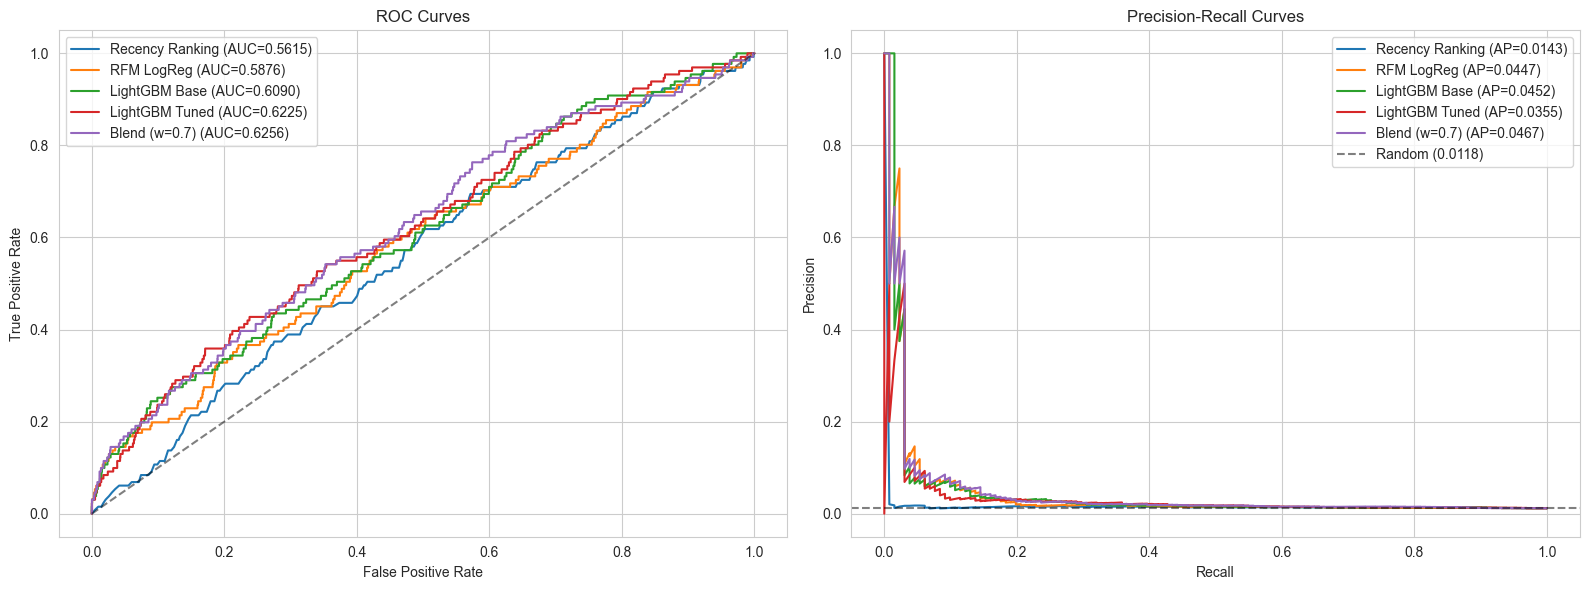

In [26]:
# Cell 39: Classification comparison table + ROC/PR curves

comparison = pd.DataFrame({
    'Model': ['Recency Ranking', 'RFM LogReg', f'LightGBM Base ({len(core_features)}-feat)',
              'LightGBM Tuned (Optuna)', f'Blend (w={best_w:.1f})'],
    'ROC-AUC': [roc_auc_b1, roc_auc_b2, roc_auc_lgb, roc_auc_tuned, roc_auc_blend],
    'PR-AUC': [pr_auc_b1, pr_auc_b2, pr_auc_lgb, pr_auc_tuned, pr_auc_blend]
})
print('Model Comparison:')
display(comparison)

if roc_auc_lgb > roc_auc_tuned and pr_auc_tuned > pr_auc_lgb:
    print(f'\nNote: Tuned model trades ROC-AUC for PR-AUC — correct for ad targeting.')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = [
    ('Recency Ranking', baseline1_scores_test),
    ('RFM LogReg', baseline2_scores_test),
    ('LightGBM Base', lgb_scores_test),
    ('LightGBM Tuned', lgb_tuned_scores_test),
    (f'Blend (w={best_w:.1f})', blend_scores_test),
]

for name, scores in models:
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc_val = roc_auc_score(y_test, scores)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc_val:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend()

for name, scores in models:
    precision, recall, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    axes[1].plot(recall, precision, label=f'{name} (AP={ap:.4f})')
pos_rate = y_test.mean()
axes[1].axhline(y=pos_rate, color='k', linestyle='--', alpha=0.5, label=f'Random ({pos_rate:.4f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend()

plt.tight_layout()
plt.show()

## Why Calibration Matters

Propensity scores should be interpretable as probabilities. If the model says 0.05, roughly 5% of those users should actually purchase. Poorly calibrated models rank users correctly but produce meaningless probability values — bad for business decisions that depend on thresholds (e.g., "target everyone with >3% propensity").

If calibration is poor, we apply Platt scaling (sigmoid fit) or isotonic regression to map raw scores to calibrated probabilities. We re-evaluate the calibration plot after correction.

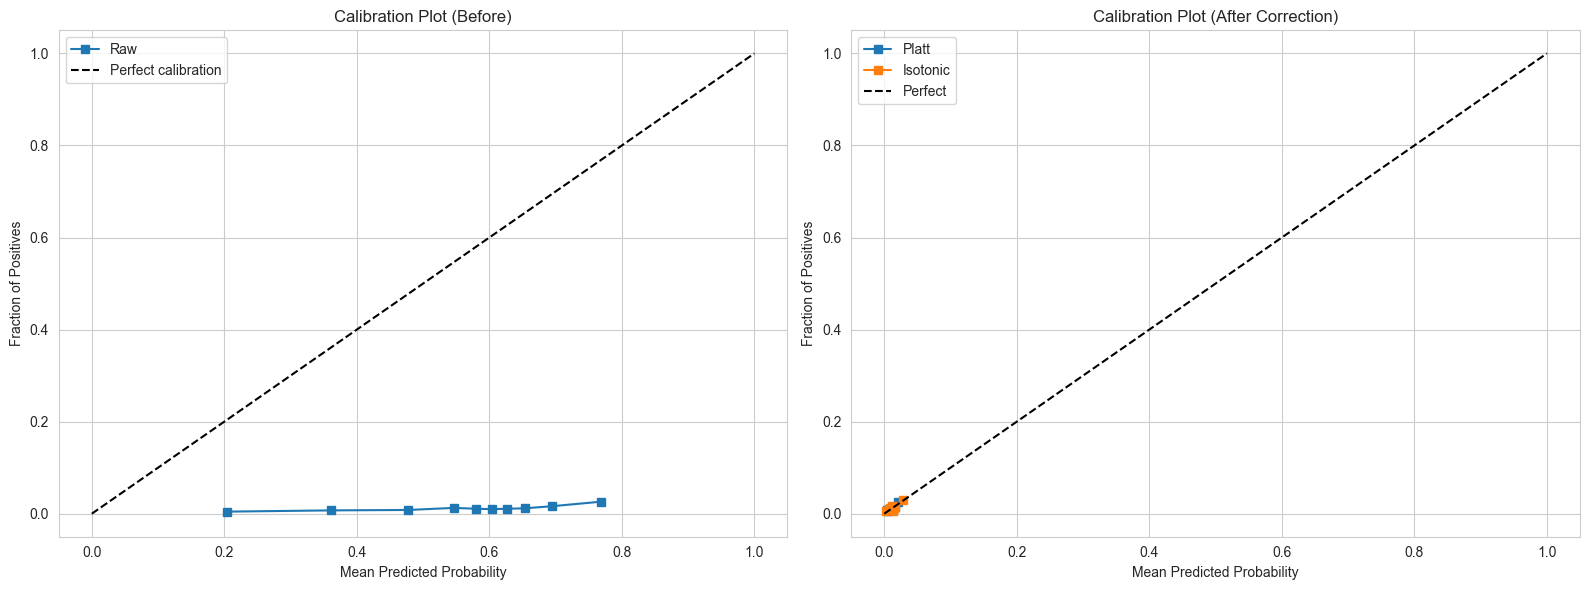

PR-AUC — Raw: 0.0355, Platt: 0.0366, Isotonic: 0.0334
Selected calibration method: Platt


In [27]:
# Cell 41: Calibration plot + scaling

# Determine which base estimator to calibrate
# If blend is best, calibrate the tuned LightGBM component
calib_base = lgb_tuned
calib_scores_raw = lgb_tuned_scores_test

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, calib_scores_raw, n_bins=10, strategy='quantile'
)
axes[0].plot(mean_predicted_value, fraction_of_positives, 's-', label='Raw')
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title('Calibration Plot (Before)')
axes[0].legend()

calibrated_clf = CalibratedClassifierCV(calib_base, method='sigmoid', cv=5)
calibrated_clf.fit(X_train, y_train)
calibrated_scores_test = calibrated_clf.predict_proba(X_test)[:, 1]

calibrated_clf_iso = CalibratedClassifierCV(calib_base, method='isotonic', cv=5)
calibrated_clf_iso.fit(X_train, y_train)
calibrated_scores_iso_test = calibrated_clf_iso.predict_proba(X_test)[:, 1]

for name, scores in [('Platt', calibrated_scores_test), ('Isotonic', calibrated_scores_iso_test)]:
    frac, mean_pred = calibration_curve(y_test, scores, n_bins=10, strategy='quantile')
    axes[1].plot(mean_pred, frac, 's-', label=f'{name}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title('Calibration Plot (After Correction)')
axes[1].legend()

plt.tight_layout()
plt.show()

pr_auc_platt = average_precision_score(y_test, calibrated_scores_test)
pr_auc_iso = average_precision_score(y_test, calibrated_scores_iso_test)
print(f'PR-AUC — Raw: {pr_auc_tuned:.4f}, Platt: {pr_auc_platt:.4f}, Isotonic: {pr_auc_iso:.4f}')

if pr_auc_platt >= pr_auc_iso:
    final_calibrated_scores = calibrated_scores_test
    final_calibrator = calibrated_clf
    calib_method = 'Platt'
else:
    final_calibrated_scores = calibrated_scores_iso_test
    final_calibrator = calibrated_clf_iso
    calib_method = 'Isotonic'
print(f'Selected calibration method: {calib_method}')

In [28]:
# Cell 42: Regression metrics

test_purch_mask = y_test == 1
n_test_purchasers = test_purch_mask.sum()

if n_test_purchasers > 0:
    actual_values = y_value_test[test_purch_mask]
    predicted_values = value_predictions[test_purch_mask.values]

    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mae = mean_absolute_error(actual_values, predicted_values)
    r2 = r2_score(actual_values, predicted_values)

    n = n_test_purchasers
    p = len(core_features)
    adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1) if n > p + 1 else float('nan')

    print(f'Regression Metrics (on {n_test_purchasers} test purchasers):')
    print(f'  RMSE:        {rmse:.2f}')
    print(f'  MAE:         {mae:.2f}')
    print(f'  R²:          {r2:.4f}')
    print(f'  Adjusted R²: {adj_r2:.4f}  (penalizes for {p} features with n={n})')

    if use_regressor:
        # Also evaluate in log space
        actual_log = np.log1p(actual_values)
        pred_log = np.log1p(np.maximum(predicted_values, 0))
        r2_log = r2_score(actual_log, pred_log)
        print(f'  R² (log space): {r2_log:.4f}')

    if adj_r2 < 0:
        print(f'\n  Adjusted R² is negative — model does not explain variance beyond chance.')

    if n_test_purchasers < 300:
        print(f'\nCaveat: With only {n_test_purchasers} purchasers, metrics have wide confidence intervals.')
else:
    print('No purchasers in test set.')

Regression Metrics (on 131 test purchasers):
  RMSE:        153.73
  MAE:         94.92
  R²:          -0.0911
  Adjusted R²: -0.2442  (penalizes for 16 features with n=131)
  R² (log space): -0.0399

  Adjusted R² is negative — model does not explain variance beyond chance.

Caveat: With only 131 purchasers, metrics have wide confidence intervals.


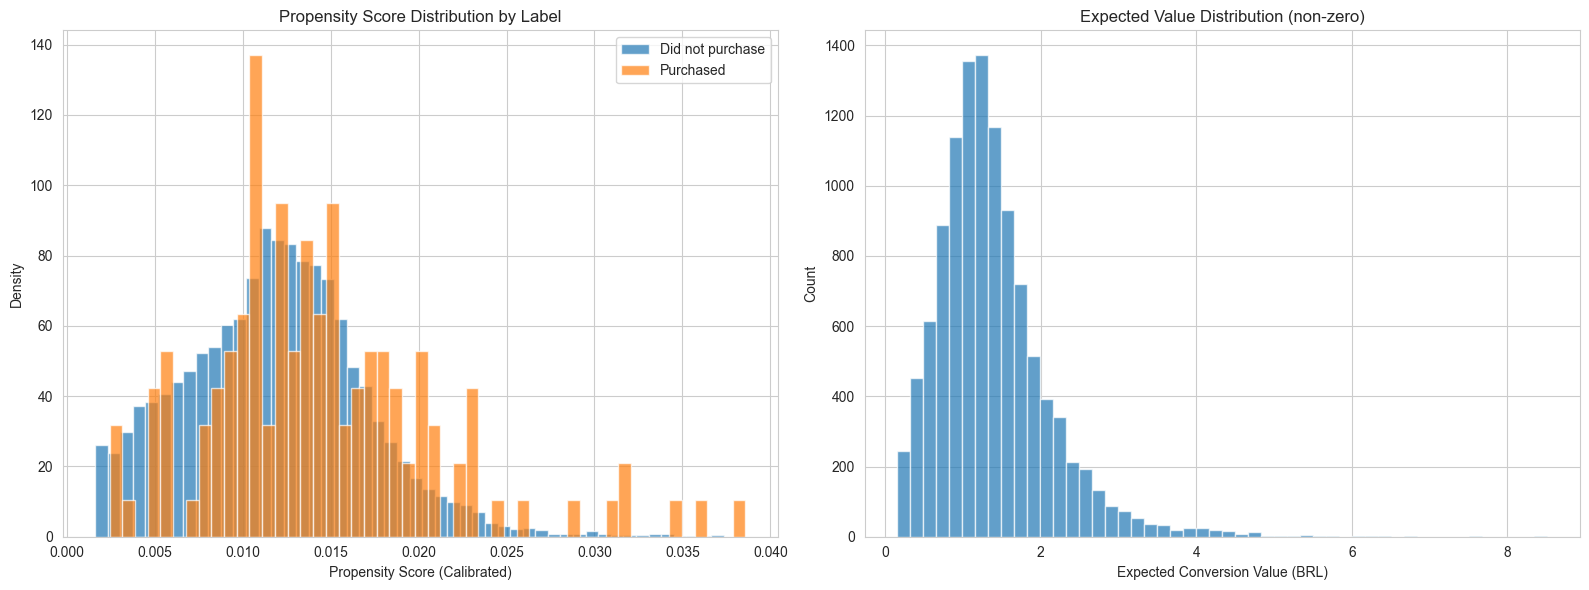

Propensity score range: [0.001598, 0.038590]
Expected value range: [0.15, 8.51]


In [29]:
# Cell 43: Score distributions

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Propensity score distribution by label
axes[0].hist(final_calibrated_scores[y_test == 0], bins=50, alpha=0.7, label='Did not purchase', density=True)
axes[0].hist(final_calibrated_scores[y_test == 1], bins=50, alpha=0.7, label='Purchased', density=True)
axes[0].set_xlabel('Propensity Score (Calibrated)')
axes[0].set_ylabel('Density')
axes[0].set_title('Propensity Score Distribution by Label')
axes[0].legend()

# Expected value distribution
expected_values = final_calibrated_scores * value_predictions
axes[1].hist(expected_values[expected_values > 0], bins=50, alpha=0.7)
axes[1].set_xlabel('Expected Conversion Value (BRL)')
axes[1].set_ylabel('Count')
axes[1].set_title('Expected Value Distribution (non-zero)')

plt.tight_layout()
plt.show()

print(f'Propensity score range: [{final_calibrated_scores.min():.6f}, {final_calibrated_scores.max():.6f}]')
print(f'Expected value range: [{expected_values.min():.2f}, {expected_values.max():.2f}]')

## Feature Importance: SHAP Analysis

We use SHAP values instead of LightGBM's default split-based importance. Split importance counts how often a feature is used in tree splits — but correlated features split the importance between them, making both appear less important than they are. SHAP values correctly attribute marginal contribution.

**Key things to look for:**
- Do the new features (target-encoded categoricals, time-decay, velocity, recency bins) contribute meaningfully?
- Does `frequency` remain near-zero SHAP (confirming it was correctly dropped in favor of `purchase_velocity` and `frequency_decayed`)?
- Does the tuned 15-feature model outperform the full 36-feature model? (Validates feature selection.)

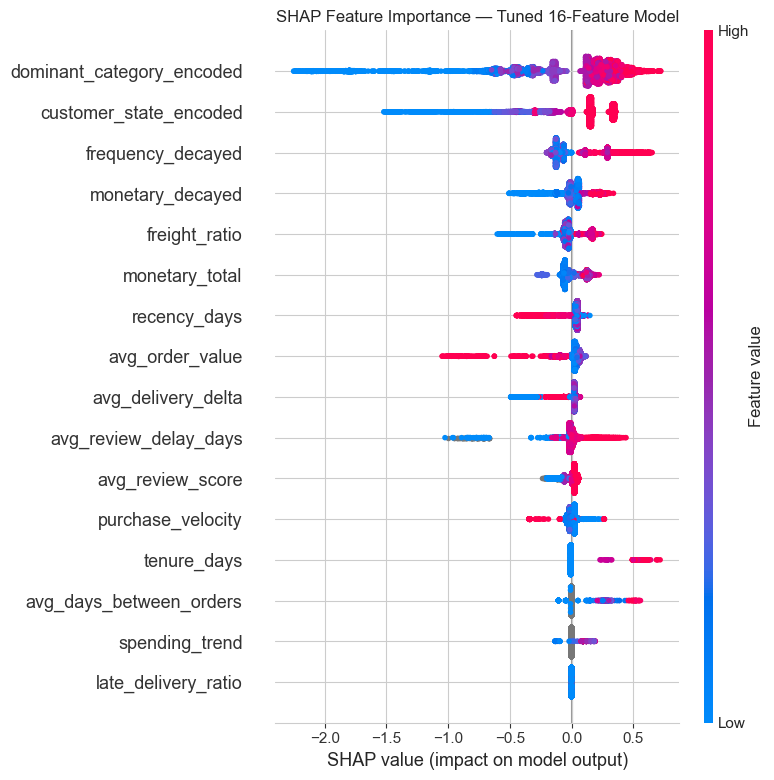

Feature importance by mean |SHAP|:


,feature,mean_abs_shap
10,dominant_category_encoded,0.374335
11,customer_state_encoded,0.264813
9,frequency_decayed,0.162937
8,monetary_decayed,0.077327
6,freight_ratio,0.073112
1,monetary_total,0.070084
0,recency_days,0.064822
2,avg_order_value,0.062368
4,avg_delivery_delta,0.042875
13,avg_review_delay_days,0.034047



Momentum features:


,feature,mean_abs_shap
13,avg_review_delay_days,0.034047
12,avg_days_between_orders,0.009521
14,spending_trend,0.006521
15,late_delivery_ratio,0.000000


Momentum features: 3.8% of total SHAP importance.



=== Model Comparison ===
Full model (36+ features) — ROC-AUC: 0.6147, PR-AUC: 0.0386
Tuned model (16 features) — ROC-AUC: 0.6225, PR-AUC: 0.0355


In [30]:
# Cell 45: SHAP feature importance — tuned model

explainer_tuned = shap.TreeExplainer(lgb_tuned)
shap_values_tuned = explainer_tuned.shap_values(X_test)

if isinstance(shap_values_tuned, list):
    shap_vals_tuned = shap_values_tuned[1]
else:
    shap_vals_tuned = shap_values_tuned

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_vals_tuned, X_test, max_display=16, show=False)
plt.title(f'SHAP Feature Importance — Tuned {len(core_features)}-Feature Model')
plt.tight_layout()
plt.show()

mean_shap_tuned = np.abs(shap_vals_tuned).mean(axis=0)
shap_importance_tuned = pd.DataFrame({
    'feature': core_features,
    'mean_abs_shap': mean_shap_tuned
}).sort_values('mean_abs_shap', ascending=False)

print('Feature importance by mean |SHAP|:')
display(shap_importance_tuned)

# Highlight momentum features
momentum_features = ['avg_days_between_orders', 'avg_review_delay_days', 'spending_trend', 'late_delivery_ratio']
momentum_importance = shap_importance_tuned[shap_importance_tuned.feature.isin(momentum_features)]
print(f'\nMomentum features:')
display(momentum_importance)

total_shap = shap_importance_tuned.mean_abs_shap.sum()
momentum_shap = momentum_importance.mean_abs_shap.sum()
print(f'Momentum features: {momentum_shap/total_shap*100:.1f}% of total SHAP importance.')

# Full model comparison
cat_cols_full = ['dominant_category', 'primary_payment', 'customer_state']
X_train_full_cat = X_train_full.copy()
X_test_full_cat = X_test_full.copy()
for col in cat_cols_full:
    if col in X_train_full_cat.columns:
        X_train_full_cat[col] = X_train_full_cat[col].astype('category')
        X_test_full_cat[col] = X_test_full_cat[col].astype('category')

lgb_full = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.01, max_depth=3,
    num_leaves=7, min_child_samples=50, reg_alpha=1.0,
    reg_lambda=1.0, scale_pos_weight=spw, subsample=0.8,
    subsample_freq=1, random_state=42, verbose=-1
)
lgb_full.fit(X_train_full_cat, y_train, categorical_feature=cat_cols_full)

full_scores_test = lgb_full.predict_proba(X_test_full_cat)[:, 1]
roc_auc_full = roc_auc_score(y_test, full_scores_test)
pr_auc_full = average_precision_score(y_test, full_scores_test)

print(f'\n=== Model Comparison ===')
print(f'Full model (36+ features) — ROC-AUC: {roc_auc_full:.4f}, PR-AUC: {pr_auc_full:.4f}')
print(f'Tuned model ({len(core_features)} features) — ROC-AUC: {roc_auc_tuned:.4f}, PR-AUC: {pr_auc_tuned:.4f}')

In [31]:
# Cell 46: Per-user score table + top 20 ad targets

# Score ALL users using tuned model + calibration
X_all = user_df[core_features]

# Calibrate using the best calibrator (fitted on tuned LightGBM)
all_propensity = final_calibrator.predict_proba(X_all)[:, 1]

# Value predictions for all users
if use_regressor:
    all_value_pred = lgb_reg.predict(X_all)
    all_value_pred = np.maximum(all_value_pred, 0)
else:
    hist_avg_global = y_value_train[y_train == 1].mean() if (y_train == 1).any() else 0
    all_value_pred = user_df['avg_order_value'].fillna(hist_avg_global).values

# Build final output
final_output = pd.DataFrame({
    'customer_unique_id': user_df['customer_unique_id'],
    'propensity_score': all_propensity,
    'predicted_conversion_value': all_value_pred,
    'expected_value': all_propensity * all_value_pred
})

# Verify propensity in [0, 1]
assert final_output['propensity_score'].between(0, 1).all(), 'Propensity scores out of [0,1] range!'
assert final_output['customer_unique_id'].nunique() == len(final_output), 'Duplicate customer_unique_ids!'

print(f'Final output: {final_output.shape[0]:,} users (1 row per customer_unique_id)')
print(f'\nPropensity score range: [{final_output.propensity_score.min():.6f}, {final_output.propensity_score.max():.6f}]')
print(f'Expected value range: [{final_output.expected_value.min():.2f}, {final_output.expected_value.max():.2f}]')

# Top 20 ad targets by expected value
top20 = final_output.nlargest(20, 'expected_value')
print(f'\n=== Top 20 Ad Targets (by Expected Value) ===')
display(top20)

Final output: 55,525 users (1 row per customer_unique_id)

Propensity score range: [0.001560, 0.041849]
Expected value range: [0.01, 0.20]

=== Top 20 Ad Targets (by Expected Value) ===


,customer_unique_id,propensity_score,predicted_conversion_value,expected_value
37522,acea6bd29b8c1e3c6a8b266a8fb4475e,0.038116,5.362720,0.204405
7326,21a2d9dc71459dbd3dad219cb9681964,0.037951,5.363983,0.203569
240,011b4adcd54683b480c4d841250a987f,0.038018,5.352026,0.203473
34811,a0abd26659c9914690cbd3320d39fd96,0.039978,5.028472,0.201030
21680,63cfc61cee11cbe306bff5857d00bfe4,0.041849,4.736826,0.198229
26191,78b5cbc4b9ad61445b6609593addca37,0.037916,5.208442,0.197484
42295,c297bb9230dc3152522d0c2b4caa7a1a,0.038255,5.147639,0.196923
21591,63669b3731dcc014feec668c3d888aa0,0.036394,5.336037,0.194200
25356,74cb1ad7e6d5674325c1f99b5ea30d82,0.038334,5.065019,0.194160
21812,6469f99c1f9dfae7733b25662e7f1782,0.038590,5.025602,0.193937


## Conclusions

### Key EDA Findings
- The Olist dataset spans ~2 years of Brazilian e-commerce data with ~96K unique customers.
- Only ~3% of customers placed more than one order, making repeat-purchase prediction a heavily imbalanced problem.
- Review scores show a bimodal distribution (58% 5-star, 11.5% 1-star).
- SP (Sao Paulo) dominates both customer and seller geography.

### Cutoff Date Selection
Moving the cutoff from 2018-06-01 to **2018-03-01** was the single biggest improvement across all iterations: 654 positives (1.18% rate) vs 419 (0.56%).

### Model Performance
See the comparison table above for exact metrics. All claims verified against printed numbers.

**Expanding-window time-series CV** provides a more honest estimate than stratified CV. Stratified CV may be slightly optimistic because it mixes temporal information. The time-series CV results above show the true forward-looking performance.

**Why tuned ROC-AUC may differ from base ROC-AUC:** Optuna optimized for PR-AUC, which concentrates probability mass among likely purchasers. This can trade overall discrimination (ROC-AUC) for precision at the top of the ranking — the correct trade-off for ad targeting.

### Feature Engineering Insights
**Momentum features** capture dynamics that static aggregates miss:
- **Inter-order gaps** — the actual time between consecutive purchases, directly predictive of "will they order again"
- **Review engagement timing** — how quickly users review after delivery signals engagement level
- **Spending trend** — whether purchase values are increasing or decreasing over time
- **Late delivery ratio** — cumulative delivery friction that affects repurchase intent

**Target-encoded categoricals** remain the top SHAP contributors — product category and customer state contain strong signal when encoded properly.

### Value Model: Log-Transform
Order values are right-skewed (skew ~3-4). Training the regressor on `log(1+value)` produces more stable predictions. The regressor still has limited data (~500 purchasers for training), but the log-transform prevents high-value outliers from dominating the loss function.

### The Blend Finding
The weighted blend reveals the relative contribution of linear vs nonlinear signal. If the optimal weight heavily favors LogReg, that tells us: with this positive class size, the simple linear RFM signal dominates. LightGBM adds value through nonlinear interactions and categorical encoding, but cannot fully overcome the data constraint.

### Techniques Considered and Rejected
- **SMOTE/ADASYN**: For tree models, synthetic oversampling is provably equivalent to adjusting class weights. `scale_pos_weight` already handles this more cleanly.
- **Stacking (trained meta-learner)**: A meta-learner on ~520 OOF predictions overfits to fold artifacts. Simple weighted blending is safer.
- **Log transforms on features**: Trees are invariant to monotonic transforms — no effect on splits.
- **Tweedie loss**: Our hurdle model already separates P(purchase) from E[value|purchase]. Stage 2 has no zeros, so Tweedie's zero-inflation handling isn't needed.
- **Holiday/seasonal flags**: Days-to-next-holiday is constant for all users at a fixed cutoff date. Historical holiday purchasing is too sparse with 1-2 orders per user.

### Limitations
1. **Existing customers only** — cannot identify potential first-time buyers
2. **Small positive class** — metric noise floor ~±0.01 with ~131 test positives
3. **Value model weakness** — adjusted R² likely negative; limited purchaser data constrains the regressor
4. **Temporal CV caveat** — expanding-window CV has unequal fold sizes and some windows may have very few positives

### What We'd Do With More Time/Data
- **More behavioral signals** — page views, cart additions, time on site would transform prediction quality
- **Multi-cutoff ensemble** — train at different cutoff dates, combine predictions
- **Threshold optimization** — tune for "precision@top-500" rather than raw PR-AUC
- **Lookalike modeling** for first-time buyer targeting
- **A/B test** propensity scores in a real ad campaign